# Examen Argumentativo 2 - Topología
Luis Fernando Alcazar Diaz
A00836287

## Parte 0. Carga y configuraciones

### 0.1. Configuraciones

In [ ]:
# -*- coding: utf-8 -*-
"""Análisis Topológico de Configuraciones en Mario Kart 8 Deluxe"""

# Instalación de dependencias
!pip install --quiet kaggle kagglehub[pandas-datasets] kmapper ripser persim scikit-learn

# Configuración de API de Kaggle
from google.colab import files
files.upload()  # Sube tu archivo kaggle.json
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/root/.kaggle"

Saving kaggle.json to kaggle.json


In [ ]:
!pip install seaborn

In [ ]:
# Importación de bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import kmapper as km
from scipy.spatial.distance import pdist, squareform
from ripser import ripser, Rips
from persim import plot_diagrams, PersistenceImager
import networkx as nx
import kagglehub
from kagglehub import KaggleDatasetAdapter
from IPython.display import display

### 0.2. Carga de datos

In [ ]:
# Carga de datasets desde Kaggle
def load_dataset(file_name):
    return kagglehub.load_dataset(
        KaggleDatasetAdapter.PANDAS,
        "marlowspringmeier/mario-kart-8-deluxe-ingame-statistics",
        file_name,
        pandas_kwargs={'sep': ';'}
    )

# Cargar todos los datasets
bodies_karts_df = load_dataset("bodies_karts.csv")
drivers_df = load_dataset("drivers.csv")
gliders_df = load_dataset("gliders.csv")
tires_df = load_dataset("tires.csv")

<ipython-input-35-c9f1a826f7e4>:3: DeprecationWarning:

load_dataset is deprecated and will be removed in a future version.

<ipython-input-35-c9f1a826f7e4>:3: DeprecationWarning:

load_dataset is deprecated and will be removed in a future version.

<ipython-input-35-c9f1a826f7e4>:3: DeprecationWarning:

load_dataset is deprecated and will be removed in a future version.

<ipython-input-35-c9f1a826f7e4>:3: DeprecationWarning:

load_dataset is deprecated and will be removed in a future version.



In [ ]:
# Función para explorar valores únicos
def explore_data(df, df_name):
    print(f"\n=== {df_name} ===")
    print("Primeras 5 filas:")
    print(df.head())

    print("\nValores únicos por columna:")
    for col in df.columns:
        uniques = df[col].unique()
        print(f"{col}: {len(uniques)} valores únicos")

# Exploración inicial
explore_data(bodies_karts_df, "Bodies/Karts")
explore_data(drivers_df, "Drivers")
explore_data(gliders_df, "Gliders")
explore_data(tires_df, "Tires")


=== Bodies/Karts ===
Primeras 5 filas:
            Body  Weight  Acceleration  On-Road traction  Off-Road Traction  \
0  Standard Kart       2             4                 3                  3   
1     Pipe Frame       1             6                 3                  4   
2         Mach 8       3             3                 2                  4   
3   Steel Driver       4             1                 1                  3   
4    Cat Cruiser       2             5                 4                  3   

   Mini-Turbo  Ground Speed  Water Speed  Anti-Gravity Speed  Air Speed  \
0           4             3            3                   3          3   
1           6             1            3                   1          1   
2           4             3            3                   5          4   
3           2             4            5                   2          0   
4           5             2            2                   3          4   

   Ground Handling  Water Handling

## Parte 1. Exploracion de datos

In [ ]:
# Configuración de estilo
try:
    plt.style.use('seaborn-v0_8')  # Try the new style name first
except:
    plt.style.use('seaborn')  # Fallback to old name if available

sns.set_palette("husl")
pd.set_option('display.max_columns', None)


In [ ]:
def comprehensive_eda(df, df_name):
    print(f"\n{'='*50}\nAnálisis de {df_name}\n{'='*50}")

    # 1. Estadísticas descriptivas
    print("\n Estadísticas Descriptivas:")
    display(df.describe(include='all').T)

    # 2. Valores únicos y frecuencias
    print("\n Valores Únicos y Distribuciones:")
    for col in df.columns:
        if df[col].dtype in ['object', 'category']:
            print(f"\n{col} (Categórico):")
            display(pd.DataFrame(df[col].value_counts()).T)
        else:
            print(f"\n{col} (Numérico):")
            print(f"- Valores únicos: {df[col].nunique()}")
            if df[col].nunique() < 15:
                print("- Distribución:")
                display(df[col].value_counts().sort_index().to_frame().T)

    # 3. Visualizaciones clave
    print("\n Visualizaciones Importantes:")

    # a. Distribución de pesos
    if 'Weight' in df.columns:
        plt.figure(figsize=(10, 5))
        sns.countplot(data=df, x='Weight', order=df['Weight'].value_counts().index)
        plt.title(f'Distribución de Peso en {df_name}')
        plt.show()

    # b. Matriz de correlación
    numeric_cols = df.select_dtypes(include=np.number).columns
    if len(numeric_cols) > 1:
        plt.figure(figsize=(12, 8))
        corr = df[numeric_cols].corr()
        sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
        plt.title(f'Correlaciones en {df_name}')
        plt.show()

    # c. Boxplots de atributos clave
    key_attributes = ['Speed', 'Acceleration', 'Handling', 'Traction'] if 'Speed' in df.columns else numeric_cols[:4]
    if len(key_attributes) > 0:
        plt.figure(figsize=(12, 6))
        df_melted = df[key_attributes].melt(var_name='Atributo', value_name='Valor')
        sns.boxplot(data=df_melted, x='Atributo', y='Valor')
        plt.title(f'Distribución de Atributos Clave en {df_name}')
        plt.xticks(rotation=45)
        plt.show()

    # d. Relación entre atributos principales
    if len(key_attributes) >= 2:
        sns.pairplot(df[key_attributes], diag_kind='kde')
        plt.suptitle(f'Relaciones entre Atributos en {df_name}', y=1.02)
        plt.show()

def analyze_combined_configs(config_df):
    """
    Función para analizar configuraciones combinadas
    """
    print("\n Analisis Configuraciones Combinadas")
    comprehensive_eda(config_df, "Configuraciones Combinadas")

    # Visualización avanzada de relaciones
    plt.figure(figsize=(14, 8))
    sns.scatterplot(data=config_df, x='Speed', y='Handling', hue='Driver_Weight',
                   size='Acceleration', sizes=(20, 200), alpha=0.7)
    plt.title("Relación Velocidad vs Manejo\n(Tamaño=Aceleración, Color=Peso del Conductor)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Top configuraciones balanceadas
    config_df['Balance_Score'] = (config_df['Speed'] * 0.4 +
                                config_df['Acceleration'] * 0.3 +
                                config_df['Handling'] * 0.3)

    print("\n Top 5 Configuraciones Balanceadas")
    display(config_df.nlargest(5, 'Balance_Score')[['Body', 'Driver', 'Glider', 'Tire',
                                                  'Speed', 'Acceleration', 'Handling',
                                                  'Balance_Score']])

In [ ]:
# Preparacion de datos (Muestreo estratificado)
def prepare_data(bodies, drivers, gliders, tires, sample_size=20):
    # Muestreo equilibrado por tipo de componente
    sample_bodies = bodies.groupby('Weight').apply(lambda x: x.sample(min(len(x), sample_size//4), random_state=42))
    sample_drivers = drivers.groupby('Weight').apply(lambda x: x.sample(min(len(x), sample_size//4), random_state=42))
    sample_gliders = gliders.sample(min(sample_size//2, len(gliders)), random_state=42)
    sample_tires = tires.sample(min(sample_size//2, len(tires)), random_state=42)

    # Combinación con pesos estratégicos
    configs = []
    for _, body in sample_bodies.iterrows():
        for _, driver in sample_drivers.iterrows():
            for _, glider in sample_gliders.iterrows():
                for _, tire in sample_tires.iterrows():
                    stats = {
                        'Speed': 0.4*body['Ground Speed'] + 0.3*driver['Ground Speed'] + 0.2*tire['Ground Speed'] + 0.1*glider['Ground Speed'],
                        'Acceleration': 0.4*body['Acceleration'] + 0.3*driver['Acceleration'] + 0.2*tire['Acceleration'] + 0.1*glider['Acceleration'],
                        'Handling': 0.3*body['Ground Handling'] + 0.3*driver['Ground Handling'] + 0.2*tire['Ground Handling'] + 0.2*glider['Ground Handling'],
                        'Traction': 0.5*body['On-Road traction'] + 0.3*driver['On-Road traction'] + 0.1*tire['On-Road traction'] + 0.1*glider['On-Road traction'],
                        'Mini-Turbo': 0.2*body['Mini-Turbo'] + 0.3*driver['Mini-Turbo'] + 0.3*tire['Mini-Turbo'] + 0.2*glider['Mini-Turbo'],
                        'Body': body['Body'],
                        'Driver': driver['Driver'],
                        'Glider': glider['Glider'],
                        'Tire': tire['Tire'],
                        'Body_Weight': body['Weight'],
                        'Driver_Weight': driver['Weight'],
                        'Tire_Weight': tire['Weight']
                    }
                    configs.append(stats)

    config_df = pd.DataFrame(configs)

    # Escalado de datos
    scaler = StandardScaler()
    scaled = scaler.fit_transform(config_df[['Speed', 'Acceleration', 'Handling', 'Traction', 'Mini-Turbo']])

    return config_df, scaled

### 1.1. Analisis datos


 Analisis Exploratorio Datos Originales

Análisis de Bodies/Karts

 Estadísticas Descriptivas:


count unique            top freq   mean       std  min  \
Body                     40     40  Standard Kart    1    NaN       NaN  NaN   
Weight                 40.0    NaN            NaN  NaN   1.95  1.299901  0.0   
Acceleration           40.0    NaN            NaN  NaN  3.325  2.067917  0.0   
On-Road traction       40.0    NaN            NaN  NaN    2.2  1.202561  0.0   
Off-Road Traction      40.0    NaN            NaN  NaN   3.45  1.753385  0.0   
Mini-Turbo             40.0    NaN            NaN  NaN  3.675  1.886355  0.0   
Ground Speed           40.0    NaN            NaN  NaN  2.925  1.456858  0.0   
Water Speed            40.0    NaN            NaN  NaN   2.65   1.16685  1.0   
Anti-Gravity Speed     40.0    NaN            NaN  NaN   2.95  1.197219  0.0   
Air Speed              40.0    NaN            NaN  NaN  2.425  1.217132  0.0   
Ground Handling        40.0    NaN            NaN  NaN    2.9  1.498717  0.0   
Water Handling         40.0    NaN            NaN  NaN    2.8  1.264911  1.0   
Anti-Gravity Handling  40.0    NaN            NaN  NaN   2.95  1.218448  1.0   
Air Handling           40.0    NaN            NaN  NaN  2.225  1.290746  0.0   

                        25%  50%  75%  max  
Body                    NaN  NaN  NaN  NaN  
Weight                  1.0  2.0  3.0  4.0  
Acceleration            2.0  3.0  5.0  7.0  
On-Road traction        1.0  2.0  3.0  4.0  
Off-Road Traction       3.0  3.0  5.0  7.0  
Mini-Turbo              3.0  4.0  5.0  7.0  
Ground Speed            2.0  3.0  4.0  5.0  
Water Speed             2.0  2.0  3.0  5.0  
Anti-Gravity Speed     2.75  3.0  4.0  5.0  
Air Speed               1.0  3.0  3.0  4.0  
Ground Handling         2.0  3.0  4.0  5.0  
Water Handling          2.0  3.0  4.0  5.0  
Anti-Gravity Handling   2.0  3.0  4.0  5.0  
Air Handling            1.0  2.5  3.0  4.0


 Valores Únicos y Distribuciones:

Body (Categórico):


Body   Standard Kart  Pipe Frame  Mach 8  Steel Driver  Cat Cruiser  \
count              1           1       1             1            1   

Body   Circuit Special  Tri-Speeder  Badwagon  Prancer  Biddybuggy  Landship  \
count                1            1         1        1           1         1   

Body   Sneeker  Sports Coupe  Gold Standard  Standard Bike  Comet  Sport Bike  \
count        1             1              1              1      1           1   

Body   The Duke  Flame Rider  Varmint  Mr. Scooty  Jet Bike  Yoshi Bike  \
count         1            1        1           1         1           1   

Body   Standard ATV  Wild Wiggler  Teddy Buggy  GLA  W 25 Silver Arrow  \
count             1             1            1    1                  1   

Body   300 SL Roadster  Blue Falcon  Tanooki Kart  B Dasher  Master Cycle  \
count                1            1             1         1             1   

Body   Streetle  P-Wing  City Tripper  Bone Rattler  Koopa Clown  Splat Buggy  \
count         1       1             1             1            1            1   

Body   Inkstriker  
count           1


Weight (Numérico):
- Valores únicos: 5
- Distribución:


Weight  0   1   2  3  4
count   6  10  10  8  6


Acceleration (Numérico):
- Valores únicos: 8
- Distribución:


Acceleration  0  1  2  3  4  5  6  7
count         3  6  8  5  3  8  5  2


On-Road traction (Numérico):
- Valores únicos: 5
- Distribución:


On-Road traction  0   1  2   3  4
count             2  13  6  13  6


Off-Road Traction (Numérico):
- Valores únicos: 8
- Distribución:


Off-Road Traction  0  1  2   3  4  5  6  7
count              3  3  3  12  8  7  2  2


Mini-Turbo (Numérico):
- Valores únicos: 8
- Distribución:


Mini-Turbo  0  1  2   3  4  5  6  7
count       3  3  3  10  6  8  5  2


Ground Speed (Numérico):
- Valores únicos: 6
- Distribución:


Ground Speed  0  1   2  3   4  5
count         2  5  10  6  11  6


Water Speed (Numérico):
- Valores únicos: 5
- Distribución:


Water Speed  1   2   3  4  5
count        5  16  12  2  5


Anti-Gravity Speed (Numérico):
- Valores únicos: 6
- Distribución:


Anti-Gravity Speed  0  1  2   3  4  5
count               2  3  5  18  9  3


Air Speed (Numérico):
- Valores únicos: 5
- Distribución:


Air Speed  0  1  2   3  4
count      3  8  5  17  7


Ground Handling (Numérico):
- Valores únicos: 6
- Distribución:


Ground Handling  0  1  2  3   4  5
count            3  6  5  9  12  5


Water Handling (Numérico):
- Valores únicos: 5
- Distribución:


Water Handling  1   2  3  4  5
count           6  13  9  7  5


Anti-Gravity Handling (Numérico):
- Valores únicos: 5
- Distribución:


Anti-Gravity Handling  1  2   3   4  5
count                  6  8  12  10  4


Air Handling (Numérico):
- Valores únicos: 5
- Distribución:


Air Handling  0  1  2   3  4
count         6  5  9  14  6


 Visualizaciones Importantes:


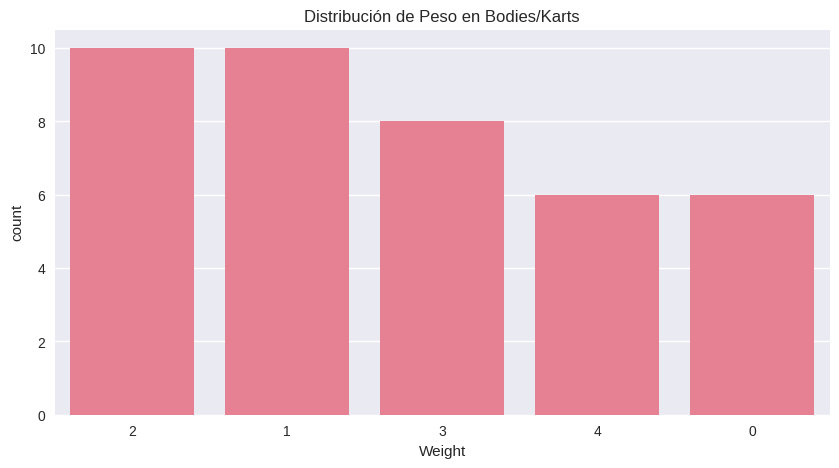

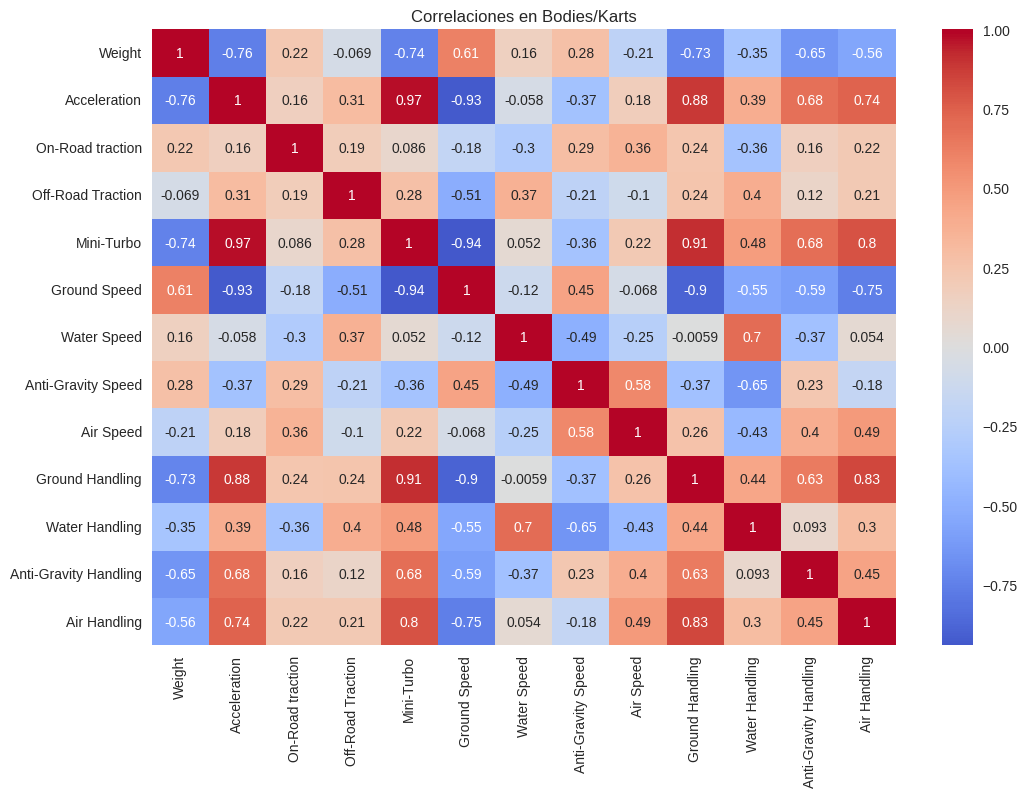

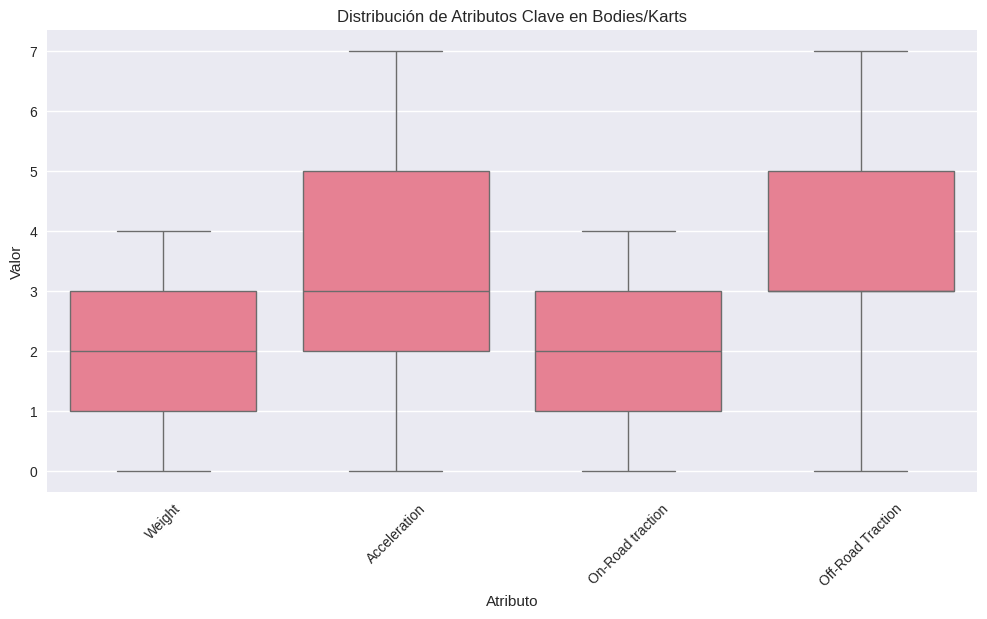

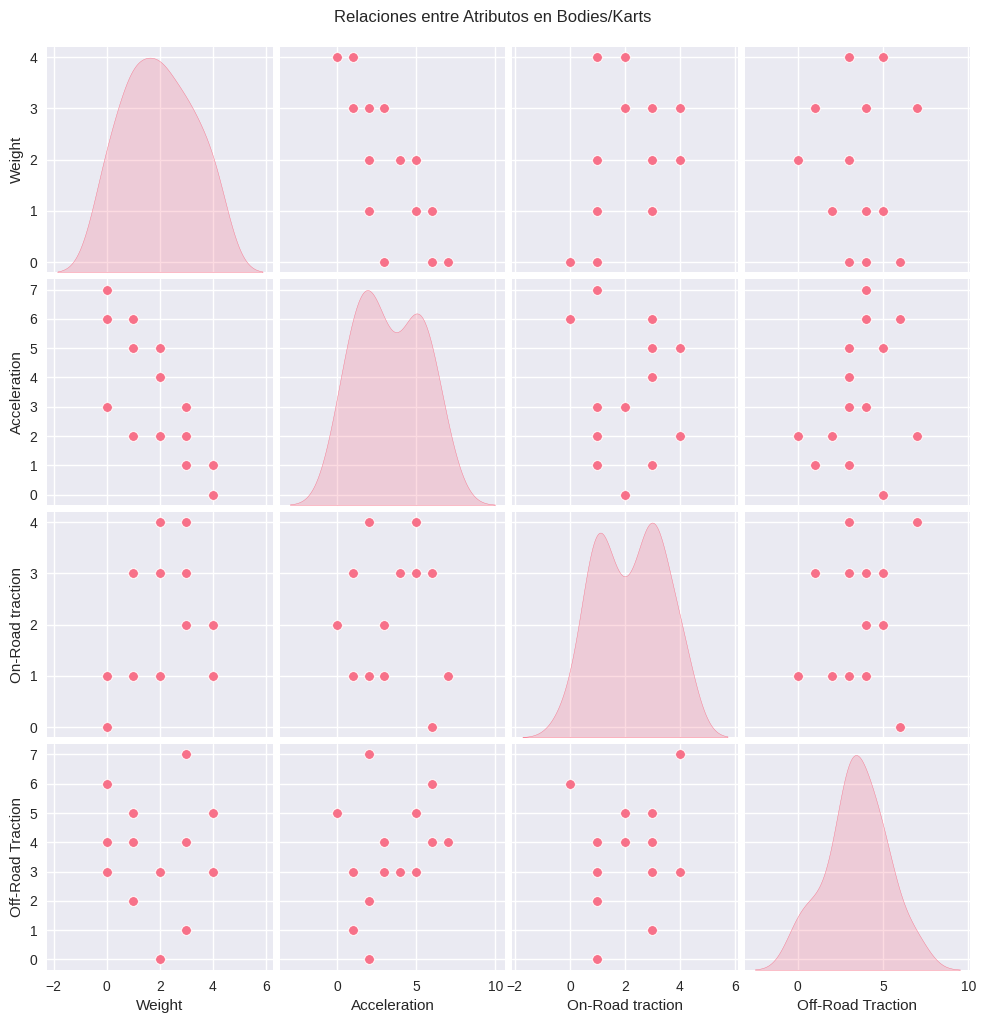


Análisis de Drivers

 Estadísticas Descriptivas:


count unique    top freq      mean       std  min  25%  \
Driver                   43     43  Mario    1       NaN       NaN  NaN  NaN   
Weight                 43.0    NaN    NaN  NaN   4.72093  3.187218  0.0  2.0   
Acceleration           43.0    NaN    NaN  NaN  2.813953  1.679793  0.0  1.0   
On-Road traction       43.0    NaN    NaN  NaN  4.767442   2.68893  1.0  3.0   
Off-Road Traction      43.0    NaN    NaN  NaN  2.418605  1.561936  0.0  1.0   
Mini-Turbo             43.0    NaN    NaN  NaN  2.651163   1.44558  0.0  2.0   
Ground Speed           43.0    NaN    NaN  NaN  4.837209  3.116242  0.0  2.0   
Water Speed            43.0    NaN    NaN  NaN  4.837209  3.116242  0.0  2.0   
Anti-Gravity Speed     43.0    NaN    NaN  NaN  4.837209  3.116242  0.0  2.0   
Air Speed              43.0    NaN    NaN  NaN  4.837209  3.116242  0.0  2.0   
Ground Handling        43.0    NaN    NaN  NaN  5.209302  2.659736  0.0  3.0   
Water Handling         43.0    NaN    NaN  NaN  5.209302  2.659736  0.0  3.0   
Anti-Gravity Handling  43.0    NaN    NaN  NaN  5.209302  2.659736  0.0  3.0   
Air Handling           43.0    NaN    NaN  NaN  5.209302  2.659736  0.0  3.0   

                       50%  75%   max  
Driver                 NaN  NaN   NaN  
Weight                 4.0  7.0  10.0  
Acceleration           3.0  4.0   5.0  
On-Road traction       4.0  7.0  10.0  
Off-Road Traction      3.0  3.5   5.0  
Mini-Turbo             3.0  4.0   5.0  
Ground Speed           5.0  7.0  10.0  
Water Speed            5.0  7.0  10.0  
Anti-Gravity Speed     5.0  7.0  10.0  
Air Speed              5.0  7.0  10.0  
Ground Handling        5.0  7.0  10.0  
Water Handling         5.0  7.0  10.0  
Anti-Gravity Handling  5.0  7.0  10.0  
Air Handling           5.0  7.0  10.0


 Valores Únicos y Distribuciones:

Driver (Categórico):


Driver  Mario  Luigi  Peach  Daisy  Yoshi  Toad  Toadette  Koopa Troopa  \
count       1      1      1      1      1     1         1             1   

Driver  Bowser  Donkey Kong  Wario  Waluigi  Rosalina  Metal Mario  \
count        1            1      1        1         1            1   

Driver  Pink Gold Peach  Lakitu  Shy Guy  Baby Mario  Baby Luigi  Baby Peach  \
count                 1       1        1           1           1           1   

Driver  Baby Daisy  Baby Rosalina  Larry  Lemmy  Wendy  Ludwig  Iggy  Roy  \
count            1              1      1      1      1       1     1    1   

Driver  Morton  Mii (medium)  Tanooki Mario  Link  Villager (male)  Isabelle  \
count        1             1              1     1                1         1   

Driver  Cat Peach  Dry Bowser  Villager (female)  Gold Mario  Dry Bones  \
count           1           1                  1           1          1   

Driver  Bowser Jr.  King Boo  Inkling Girl  Inkling Boy  
count            1         1             1            1


Weight (Numérico):
- Valores únicos: 11
- Distribución:


Weight  0   1   2   3   4   5   6   7   8   9   10
count    4   3   6   6   3   3   5   3   3   2   5


Acceleration (Numérico):
- Valores únicos: 6
- Distribución:


Acceleration  0  1  2  3   4  5
count         4  9  5  6  11  8


On-Road traction (Numérico):
- Valores únicos: 10
- Distribución:


On-Road traction  1   2   3   4   5   6   7   8   9   10
count              3   6   8   8   4   2   3   3   3   3


Off-Road Traction (Numérico):
- Valores únicos: 6
- Distribución:


Off-Road Traction  0   1  2   3  4  5
count              5  10  6  11  6  5


Mini-Turbo (Numérico):
- Valores únicos: 6
- Distribución:


Mini-Turbo  0  1  2   3  4  5
count       4  6  8  12  9  4


Ground Speed (Numérico):
- Valores únicos: 11
- Distribución:


Ground Speed  0   1   2   3   4   5   6   7   8   9   10
count          4   3   6   3   3   6   5   3   3   3   4


Water Speed (Numérico):
- Valores únicos: 11
- Distribución:


Water Speed  0   1   2   3   4   5   6   7   8   9   10
count         4   3   6   3   3   6   5   3   3   3   4


Anti-Gravity Speed (Numérico):
- Valores únicos: 11
- Distribución:


Anti-Gravity Speed  0   1   2   3   4   5   6   7   8   9   10
count                4   3   6   3   3   6   5   3   3   3   4


Air Speed (Numérico):
- Valores únicos: 11
- Distribución:


Air Speed  0   1   2   3   4   5   6   7   8   9   10
count       4   3   6   3   3   6   5   3   3   3   4


Ground Handling (Numérico):
- Valores únicos: 11
- Distribución:


Ground Handling  0   1   2   3   4   5   6   7   8   9   10
count             2   2   3   6   3   8   3   6   6   2   2


Water Handling (Numérico):
- Valores únicos: 11
- Distribución:


Water Handling  0   1   2   3   4   5   6   7   8   9   10
count            2   2   3   6   3   8   3   6   6   2   2


Anti-Gravity Handling (Numérico):
- Valores únicos: 11
- Distribución:


Anti-Gravity Handling  0   1   2   3   4   5   6   7   8   9   10
count                   2   2   3   6   3   8   3   6   6   2   2


Air Handling (Numérico):
- Valores únicos: 11
- Distribución:


Air Handling  0   1   2   3   4   5   6   7   8   9   10
count          2   2   3   6   3   8   3   6   6   2   2


 Visualizaciones Importantes:


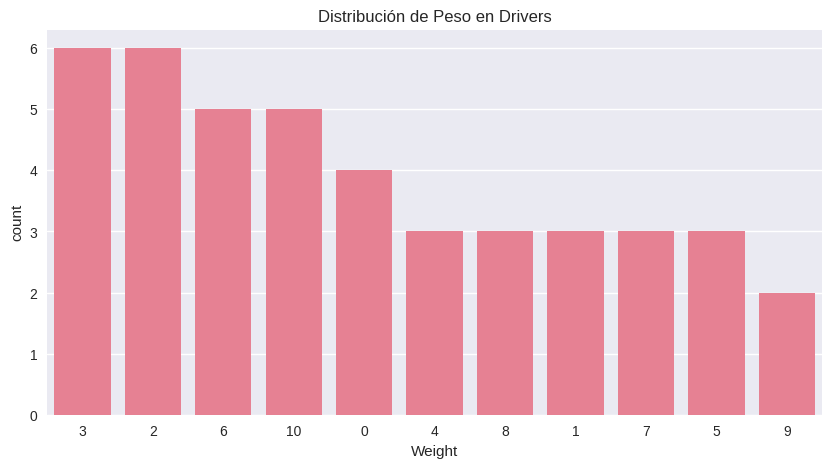

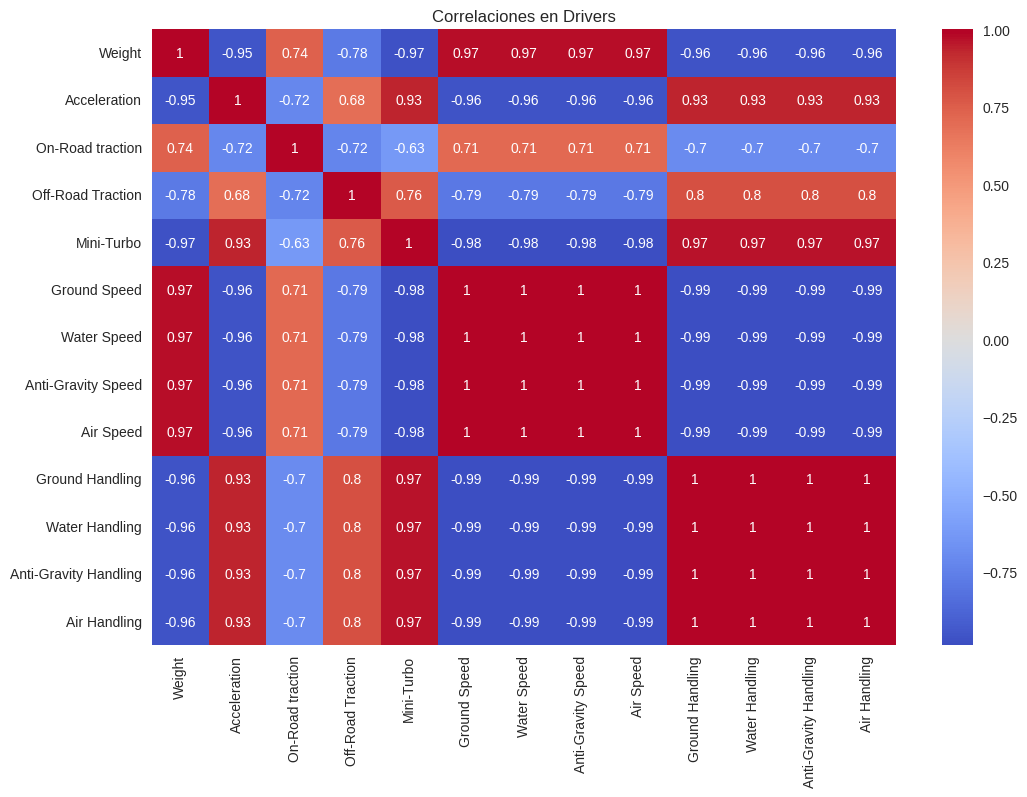

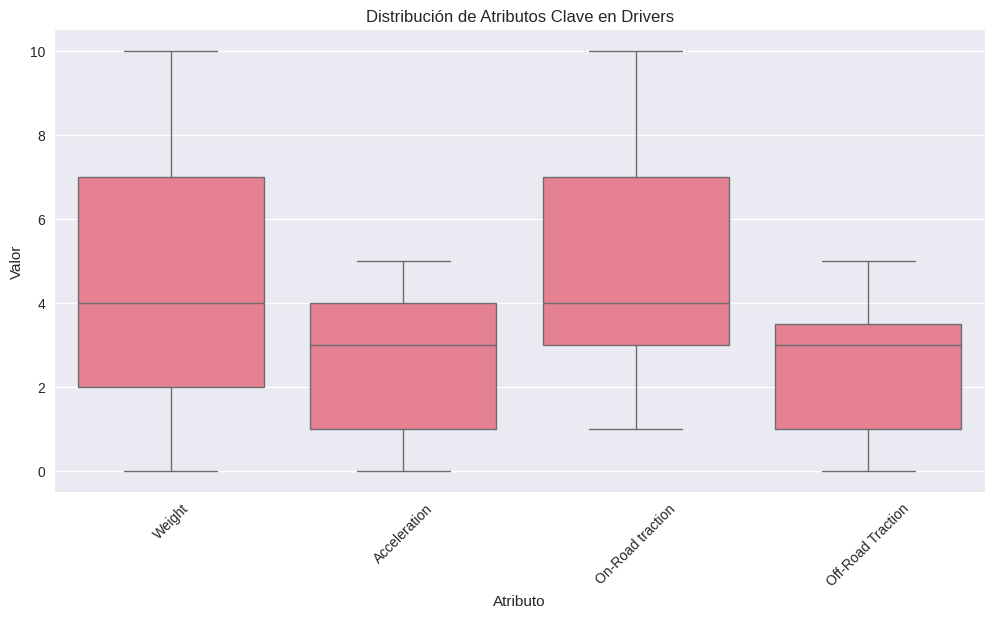

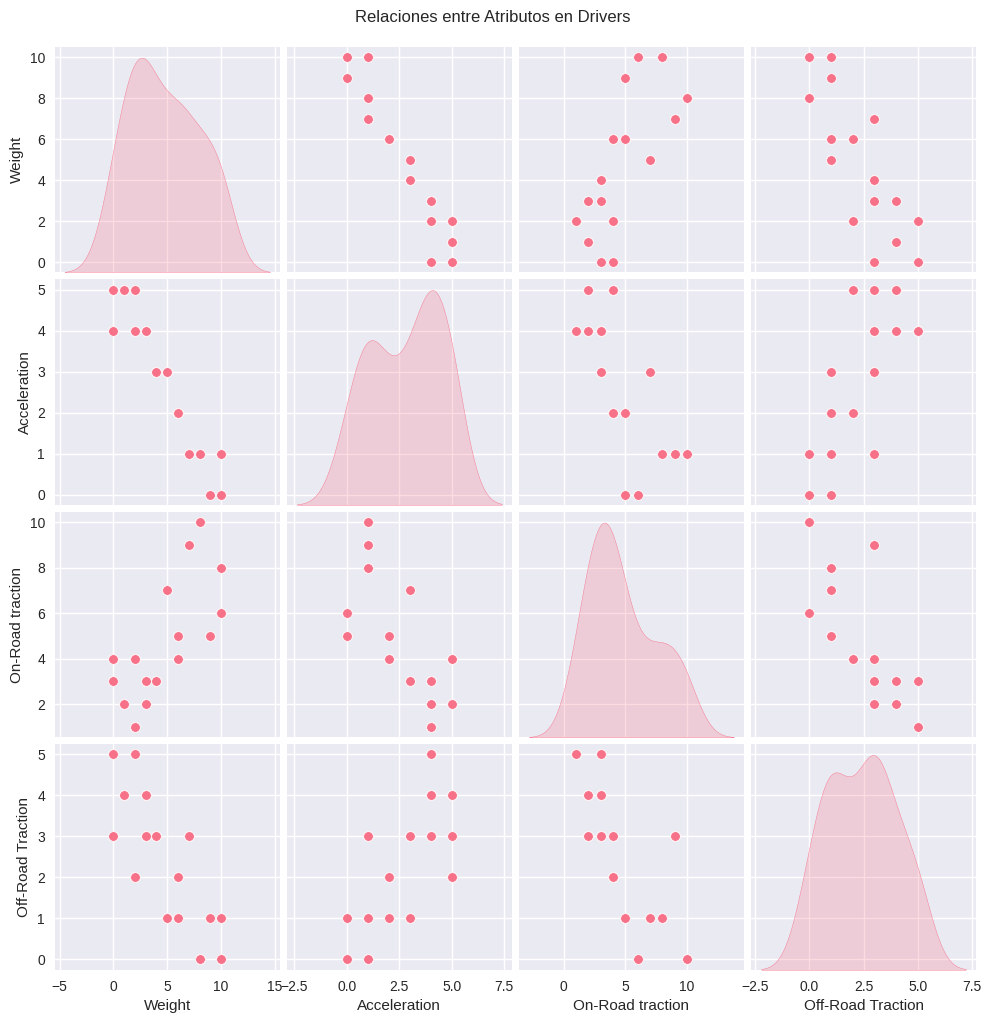


Análisis de Gliders

 Estadísticas Descriptivas:


count unique           top freq      mean       std  \
Glider                   14     14  Super Glider    1       NaN       NaN   
Weight                 14.0    NaN           NaN  NaN  0.928571  0.730046   
Acceleration           14.0    NaN           NaN  NaN  1.571429  0.513553   
On-Road traction       14.0    NaN           NaN  NaN       1.5  0.518875   
Off-Road Traction      14.0    NaN           NaN  NaN       0.5  0.518875   
Mini-Turbo             14.0    NaN           NaN  NaN  1.571429  0.513553   
Ground Speed           14.0    NaN           NaN  NaN  0.428571  0.513553   
Water Speed            14.0    NaN           NaN  NaN       0.5  0.518875   
Anti-Gravity Speed     14.0    NaN           NaN  NaN  0.785714  0.425815   
Air Speed              14.0    NaN           NaN  NaN  1.428571  0.513553   
Ground Handling        14.0    NaN           NaN  NaN       1.0       0.0   
Water Handling         14.0    NaN           NaN  NaN       0.5  0.518875   
Anti-Gravity Handling  14.0    NaN           NaN  NaN       0.5  0.518875   
Air Handling           14.0    NaN           NaN  NaN  1.571429  0.513553   

                       min   25%  50%  75%  max  
Glider                 NaN   NaN  NaN  NaN  NaN  
Weight                 0.0  0.25  1.0  1.0  2.0  
Acceleration           1.0   1.0  2.0  2.0  2.0  
On-Road traction       1.0   1.0  1.5  2.0  2.0  
Off-Road Traction      0.0   0.0  0.5  1.0  1.0  
Mini-Turbo             1.0   1.0  2.0  2.0  2.0  
Ground Speed           0.0   0.0  0.0  1.0  1.0  
Water Speed            0.0   0.0  0.5  1.0  1.0  
Anti-Gravity Speed     0.0   1.0  1.0  1.0  1.0  
Air Speed              1.0   1.0  1.0  2.0  2.0  
Ground Handling        1.0   1.0  1.0  1.0  1.0  
Water Handling         0.0   0.0  0.5  1.0  1.0  
Anti-Gravity Handling  0.0   0.0  0.5  1.0  1.0  
Air Handling           1.0   1.0  2.0  2.0  2.0


 Valores Únicos y Distribuciones:

Glider (Categórico):


Glider  Super Glider  Cloud Glider  Wario Wing   Waddle Wing  Peach Parasol  \
count              1             1            1            1              1   

Glider  Parachute  Parafoil  Flower Glider    Bowser Kite  Plane Glider    \
count           1         1                1            1               1   

Glider  MKTV Parafoil  Gold Glider  Hylian Kite  Paper Glider  
count               1            1            1             1


Weight (Numérico):
- Valores únicos: 3
- Distribución:


Weight  0  1  2
count   4  7  3


Acceleration (Numérico):
- Valores únicos: 2
- Distribución:


Acceleration  1  2
count         6  8


On-Road traction (Numérico):
- Valores únicos: 2
- Distribución:


On-Road traction  1  2
count             7  7


Off-Road Traction (Numérico):
- Valores únicos: 2
- Distribución:


Off-Road Traction  0  1
count              7  7


Mini-Turbo (Numérico):
- Valores únicos: 2
- Distribución:


Mini-Turbo  1  2
count       6  8


Ground Speed (Numérico):
- Valores únicos: 2
- Distribución:


Ground Speed  0  1
count         8  6


Water Speed (Numérico):
- Valores únicos: 2
- Distribución:


Water Speed  0  1
count        7  7


Anti-Gravity Speed (Numérico):
- Valores únicos: 2
- Distribución:


Anti-Gravity Speed  0   1
count               3  11


Air Speed (Numérico):
- Valores únicos: 2
- Distribución:


Air Speed  1  2
count      8  6


Ground Handling (Numérico):
- Valores únicos: 1
- Distribución:


Ground Handling   1
count            14


Water Handling (Numérico):
- Valores únicos: 2
- Distribución:


Water Handling  0  1
count           7  7


Anti-Gravity Handling (Numérico):
- Valores únicos: 2
- Distribución:


Anti-Gravity Handling  0  1
count                  7  7


Air Handling (Numérico):
- Valores únicos: 2
- Distribución:


Air Handling  1  2
count         6  8


 Visualizaciones Importantes:


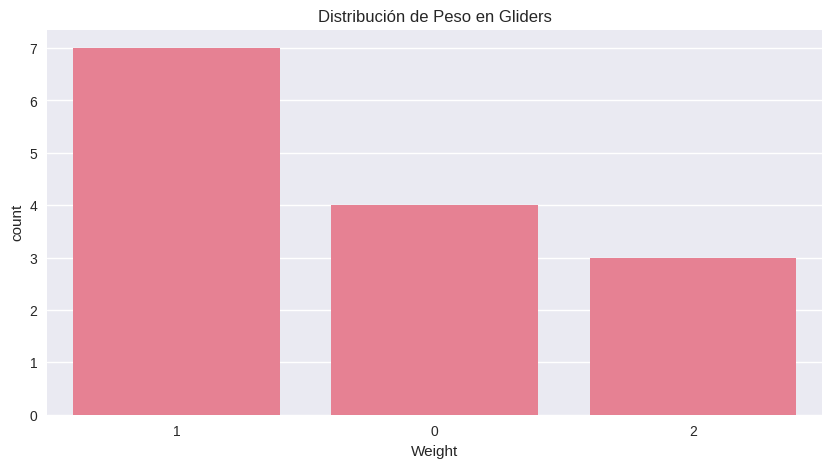

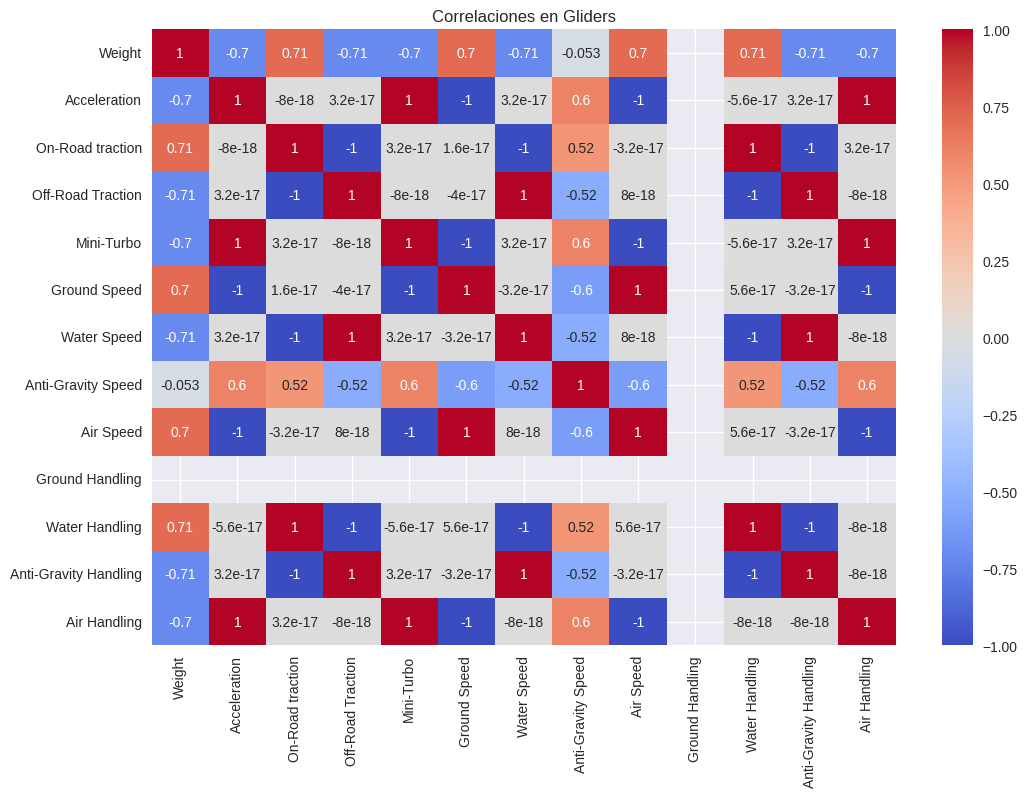

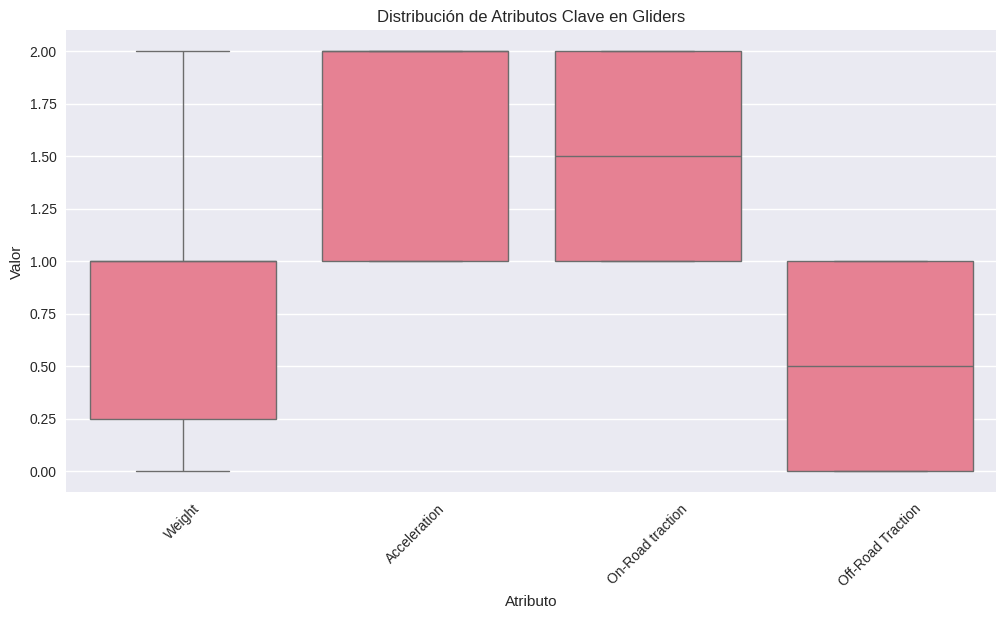

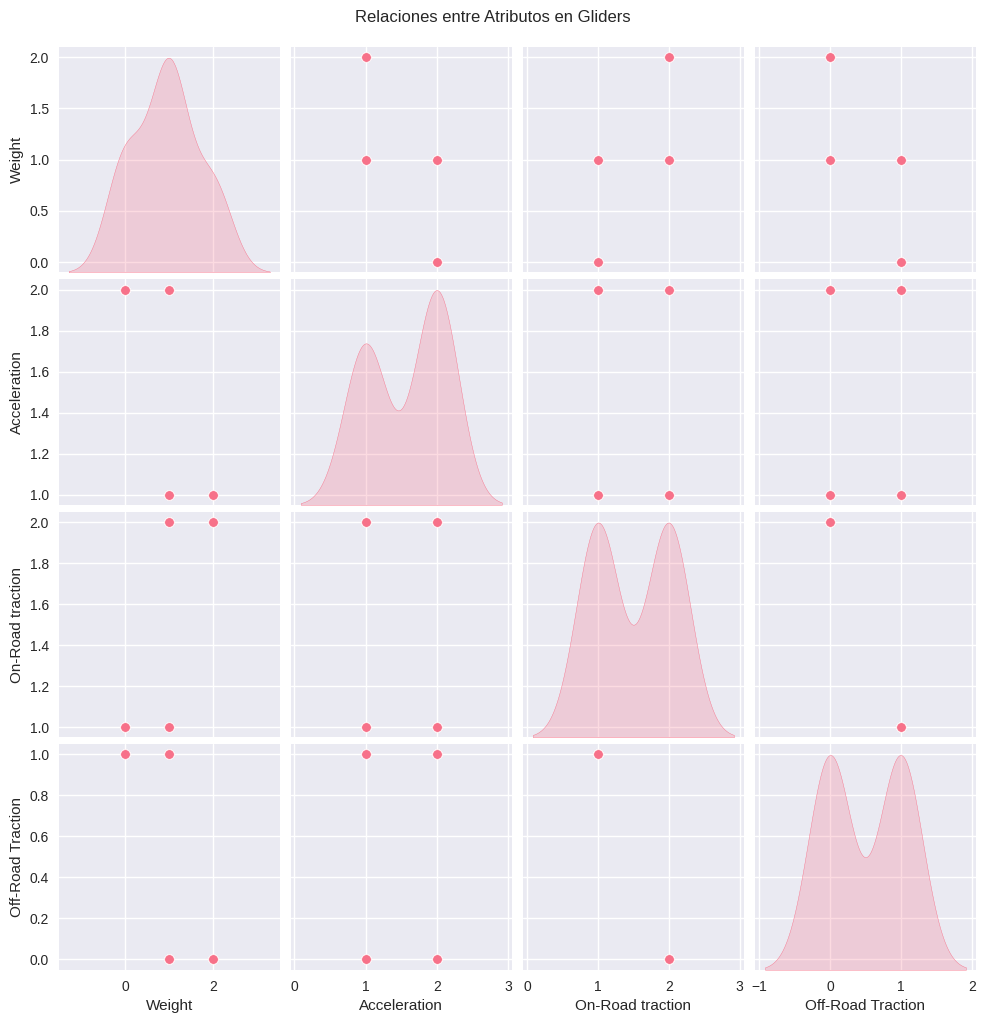


Análisis de Tires

 Estadísticas Descriptivas:


count unique       top freq      mean       std  min  \
Tire                     21     21  Standard    1       NaN       NaN  NaN   
Weight                 21.0    NaN       NaN  NaN  2.142857   1.38873  0.0   
Acceleration           21.0    NaN       NaN  NaN       3.0  1.760682  0.0   
On-Road traction       21.0    NaN       NaN  NaN  2.333333  1.316561  0.0   
Off-Road Traction      21.0    NaN       NaN  NaN  3.809524  2.337072  0.0   
Mini-Turbo             21.0    NaN       NaN  NaN   2.47619  1.939563  0.0   
Ground Speed           21.0    NaN       NaN  NaN  2.285714  1.270545  0.0   
Water Speed            21.0    NaN       NaN  NaN  2.333333  1.154701  0.0   
Anti-Gravity Speed     21.0    NaN       NaN  NaN  2.095238  1.261141  0.0   
Air Speed              21.0    NaN       NaN  NaN       2.0  1.140175  0.0   
Ground Handling        21.0    NaN       NaN  NaN  2.380952  1.283596  0.0   
Water Handling         21.0    NaN       NaN  NaN  2.190476   1.40068  0.0   
Anti-Gravity Handling  21.0    NaN       NaN  NaN  2.380952   1.20317  0.0   
Air Handling           21.0    NaN       NaN  NaN  2.333333  1.316561  0.0   

                       25%  50%  75%  max  
Tire                   NaN  NaN  NaN  NaN  
Weight                 1.0  2.0  3.0  4.0  
Acceleration           2.0  3.0  4.0  6.0  
On-Road traction       1.0  2.0  3.0  4.0  
Off-Road Traction      2.0  4.0  6.0  7.0  
Mini-Turbo             1.0  2.0  4.0  6.0  
Ground Speed           1.0  2.0  3.0  4.0  
Water Speed            2.0  2.0  3.0  4.0  
Anti-Gravity Speed     1.0  2.0  2.0  4.0  
Air Speed              1.0  2.0  3.0  4.0  
Ground Handling        2.0  2.0  3.0  4.0  
Water Handling         1.0  2.0  3.0  4.0  
Anti-Gravity Handling  2.0  2.0  3.0  4.0  
Air Handling           1.0  2.0  3.0  4.0


 Valores Únicos y Distribuciones:

Tire (Categórico):


Tire   Standard  Monster  Roller  Slim  Slick  Metal  Button  Off-Road  \
count         1        1       1     1      1      1       1         1   

Tire   Sponge  Wood  Cushion  Blue Standard  Hot Monster  Azure Roller  \
count       1     1        1              1            1             1   

Tire   Crimson Slim  Cyber Slick  Retro Off-Road  Gold Tires  GLA Tires  \
count             1            1               1           1          1   

Tire   Triforce Tires  Leaf Tires  
count               1           1


Weight (Numérico):
- Valores únicos: 5
- Distribución:


Weight  0  1  2  3  4
count   4  2  6  5  4


Acceleration (Numérico):
- Valores únicos: 7
- Distribución:


Acceleration  0  1  2  3  4  5  6
count         2  2  5  3  5  2  2


On-Road traction (Numérico):
- Valores únicos: 5
- Distribución:


On-Road traction  0  1  2  3  4
count             2  4  5  5  5


Off-Road Traction (Numérico):
- Valores únicos: 8
- Distribución:


Off-Road Traction  0  1  2  3  4  5  6  7
count              2  3  2  2  2  3  5  2


Mini-Turbo (Numérico):
- Valores únicos: 7
- Distribución:


Mini-Turbo  0  1  2  3  4  5  6
count       4  3  5  3  2  2  2


Ground Speed (Numérico):
- Valores únicos: 5
- Distribución:


Ground Speed  0  1  2  3  4
count         2  4  5  6  4


Water Speed (Numérico):
- Valores únicos: 5
- Distribución:


Water Speed  0  1  2  3  4
count        2  2  7  7  3


Anti-Gravity Speed (Numérico):
- Valores únicos: 4
- Distribución:


Anti-Gravity Speed  0  1   2  4
count               2  4  10  5


Air Speed (Numérico):
- Valores únicos: 5
- Distribución:


Air Speed  0  1  2  3  4
count      2  5  7  5  2


Ground Handling (Numérico):
- Valores únicos: 5
- Distribución:


Ground Handling  0  1  2  3  4
count            2  3  6  5  5


Water Handling (Numérico):
- Valores únicos: 5
- Distribución:


Water Handling  0  1  2  3  4
count           2  7  2  5  5


Anti-Gravity Handling (Numérico):
- Valores únicos: 5
- Distribución:


Anti-Gravity Handling  0  1  2  3  4
count                  2  2  7  6  4


Air Handling (Numérico):
- Valores únicos: 5
- Distribución:


Air Handling  0  1  2  3  4
count         2  4  5  5  5


 Visualizaciones Importantes:


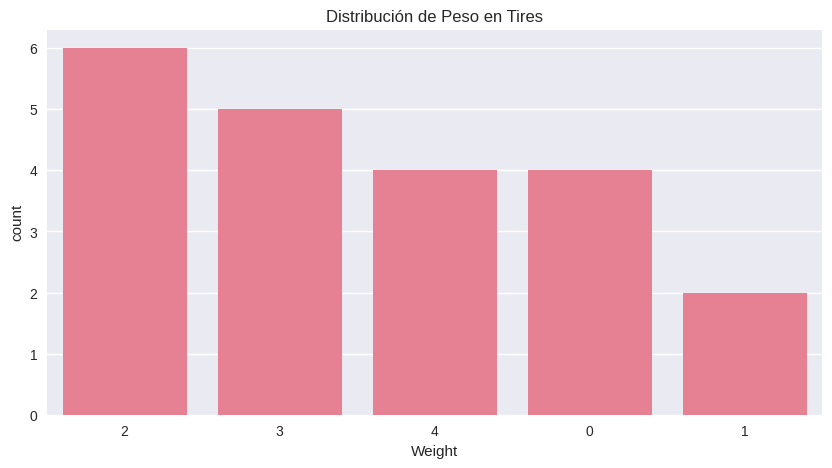

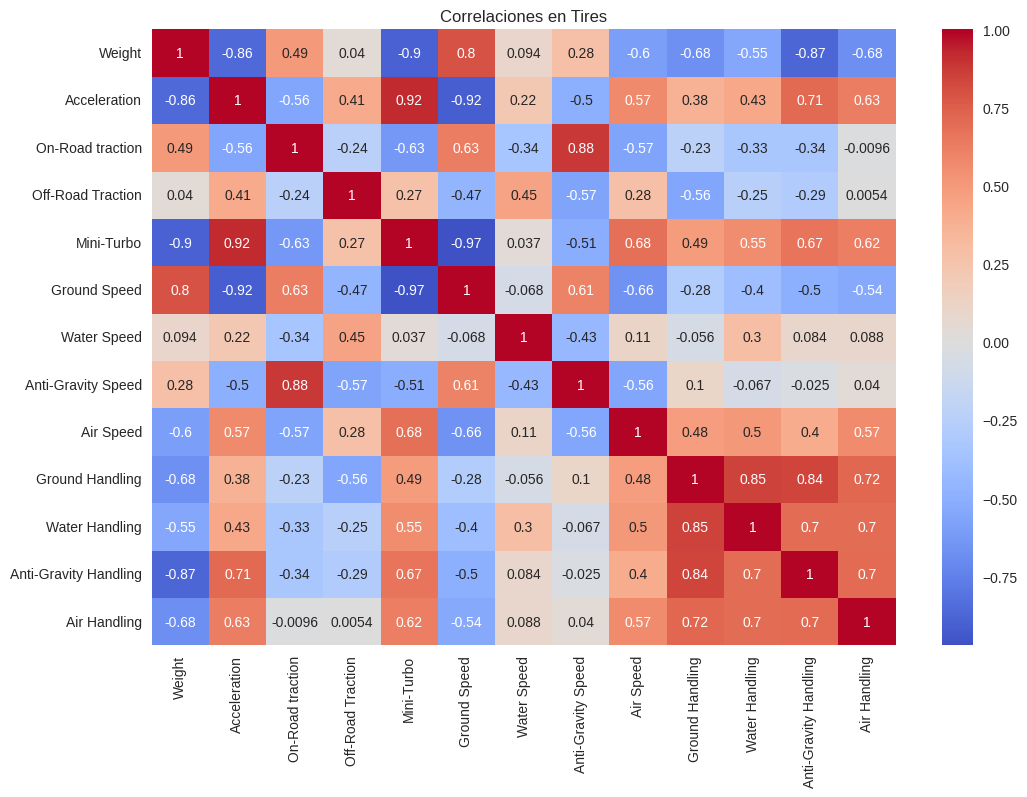

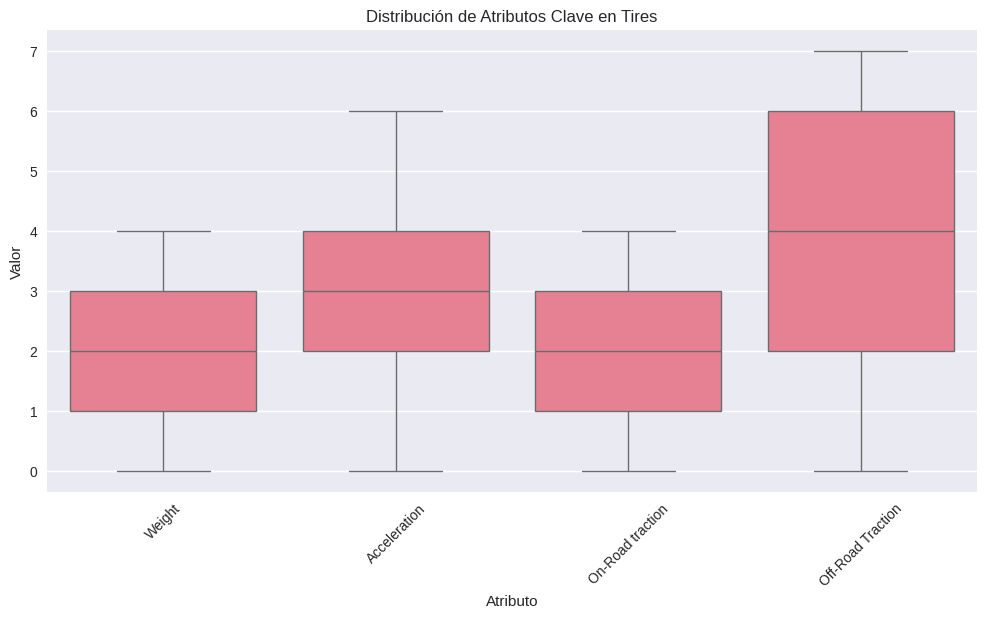

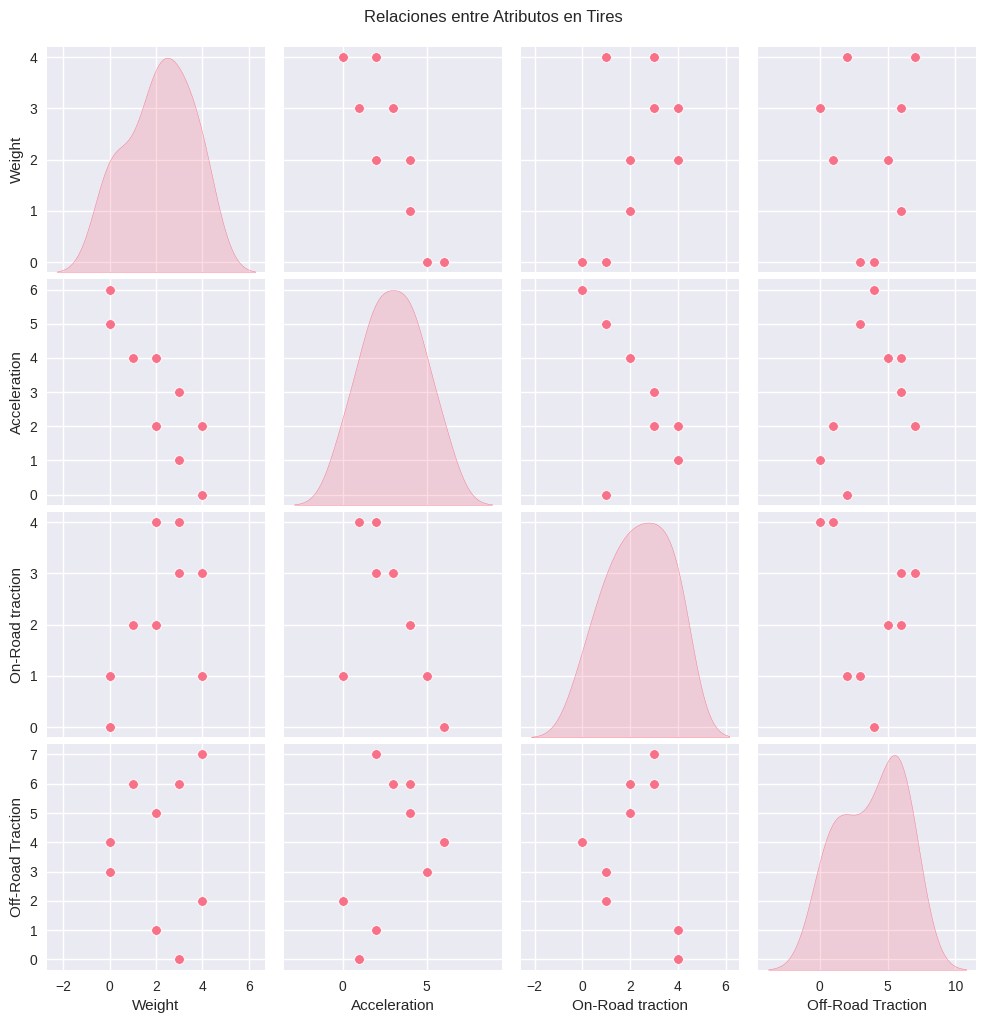

<ipython-input-39-f6a76c956495>:4: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-39-f6a76c956495>:5: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.




 Analisis Configuraciones Combinadas

Análisis de Configuraciones Combinadas

 Estadísticas Descriptivas:


count unique             top   freq      mean       std  \
Speed          102500.0    NaN             NaN    NaN  3.188049  1.135555   
Acceleration   102500.0    NaN             NaN    NaN  2.873512  1.049903   
Handling       102500.0    NaN             NaN    NaN  3.011902  0.956589   
Traction       102500.0    NaN             NaN    NaN  2.886098  0.989514   
Mini-Turbo     102500.0    NaN             NaN    NaN  2.390927  0.732684   
Body             102500     25      Biddybuggy   4100       NaN       NaN   
Driver           102500     41      Baby Daisy   2500       NaN       NaN   
Glider           102500     10  Plane Glider    10250       NaN       NaN   
Tire             102500     10        Standard  10250       NaN       NaN   
Body_Weight    102500.0    NaN             NaN    NaN       2.0   1.41422   
Driver_Weight  102500.0    NaN             NaN    NaN  4.829268  3.184601   
Tire_Weight    102500.0    NaN             NaN    NaN       2.7  1.004992   

               min  25%  50%  75%   max  
Speed          0.2  2.4  3.2  4.0   5.9  
Acceleration   0.1  2.1  2.9  3.7   5.3  
Handling       0.2  2.3  3.0  3.7   5.5  
Traction       0.5  2.2  2.8  3.5   5.6  
Mini-Turbo     0.2  1.9  2.4  2.9   4.5  
Body           NaN  NaN  NaN  NaN   NaN  
Driver         NaN  NaN  NaN  NaN   NaN  
Glider         NaN  NaN  NaN  NaN   NaN  
Tire           NaN  NaN  NaN  NaN   NaN  
Body_Weight    0.0  1.0  2.0  3.0   4.0  
Driver_Weight  0.0  2.0  5.0  7.0  10.0  
Tire_Weight    1.0  2.0  2.5  4.0   4.0


 Valores Únicos y Distribuciones:

Speed (Numérico):
- Valores únicos: 128

Acceleration (Numérico):
- Valores únicos: 118

Handling (Numérico):
- Valores únicos: 79

Traction (Numérico):
- Valores únicos: 105

Mini-Turbo (Numérico):
- Valores únicos: 87

Body (Categórico):


Body   Biddybuggy  Landship  Splat Buggy  Mr. Scooty  Streetle  \
count        4100      4100         4100        4100      4100   

Body   W 25 Silver Arrow  Prancer  Varmint  Pipe Frame  Wild Wiggler  \
count               4100     4100     4100        4100          4100   

Body   300 SL Roadster  Cat Cruiser  The Duke  Standard Kart  Teddy Buggy  \
count             4100         4100      4100           4100         4100   

Body   Circuit Special  P-Wing  Mach 8  Inkstriker  Sports Coupe  \
count             4100    4100    4100        4100          4100   

Body   Steel Driver  Tri-Speeder  Bone Rattler  Badwagon   GLA  
count          4100         4100          4100      4100  4100


Driver (Categórico):


Driver  Baby Daisy  Lemmy  Baby Peach  Baby Rosalina  Baby Mario  Baby Luigi  \
count         2500   2500        2500           2500        2500        2500   

Driver  Dry Bones  Toadette  Koopa Troopa  Bowser Jr.  Lakitu  Isabelle  Toad  \
count        2500      2500          2500        2500    2500      2500  2500   

Driver  Shy Guy  Inkling Girl  Larry  Villager (female)  Peach  Daisy  Yoshi  \
count      2500          2500   2500               2500   2500   2500   2500   

Driver  Tanooki Mario  Villager (male)  Inkling Boy  Luigi  Mii (medium)  \
count            2500             2500         2500   2500          2500   

Driver  Ludwig  Mario  Iggy  Rosalina  Link  King Boo  Donkey Kong  Waluigi  \
count     2500   2500  2500      2500  2500      2500         2500     2500   

Driver   Roy  Dry Bowser  Wario  Metal Mario  Gold Mario  Pink Gold Peach  \
count   2500        2500   2500         2500        2500             2500   

Driver  Bowser  Morton  
count     2500    2500


Glider (Categórico):


Glider  Plane Glider    Gold Glider  Super Glider  Hylian Kite  Parachute  \
count            10250        10250         10250        10250      10250   

Glider  Bowser Kite  Wario Wing   Cloud Glider  Paper Glider  Peach Parasol  
count         10250        10250         10250         10250          10250


Tire (Categórico):


Tire   Standard  Gold Tires  Cyber Slick  Monster  Sponge  Metal  \
count     10250       10250        10250    10250   10250  10250   

Tire   Blue Standard   Slim  GLA Tires  Retro Off-Road  
count          10250  10250      10250           10250


Body_Weight (Numérico):
- Valores únicos: 5
- Distribución:


Body_Weight      0      1      2      3      4
count        20500  20500  20500  20500  20500


Driver_Weight (Numérico):
- Valores únicos: 11
- Distribución:


Driver_Weight     0     1      2      3     4     5      6     7     8     9   \
count          10000  7500  12500  12500  7500  7500  12500  7500  7500  5000   

Driver_Weight     10  
count          12500


Tire_Weight (Numérico):
- Valores únicos: 4
- Distribución:


Tire_Weight      1      2      3      4
count        10250  41000  20500  30750


 Visualizaciones Importantes:


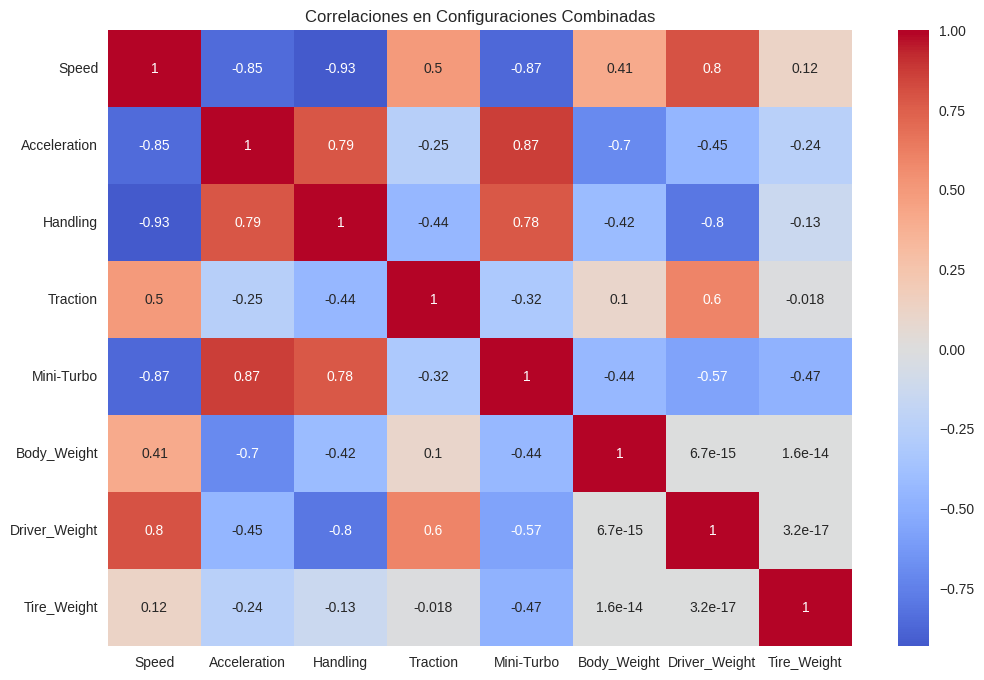

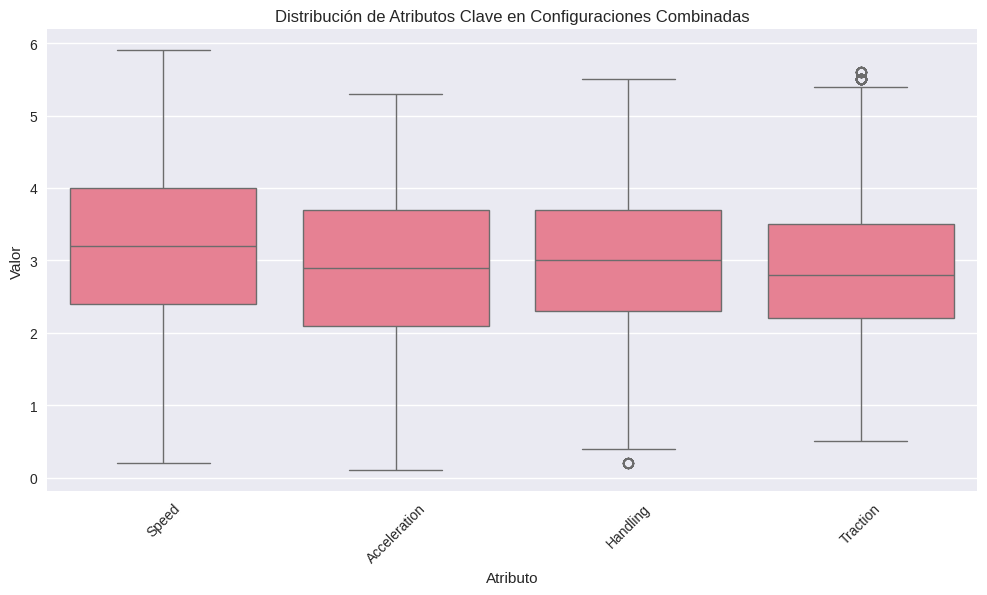

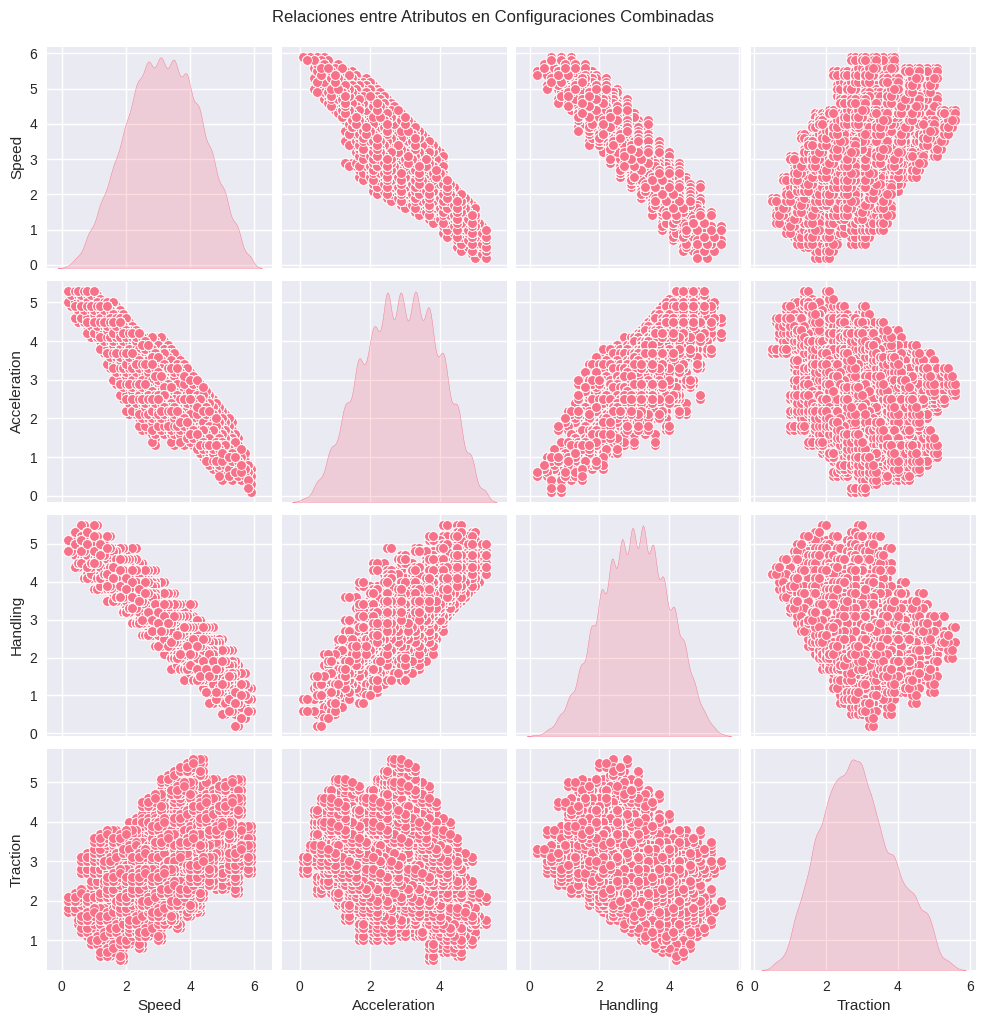

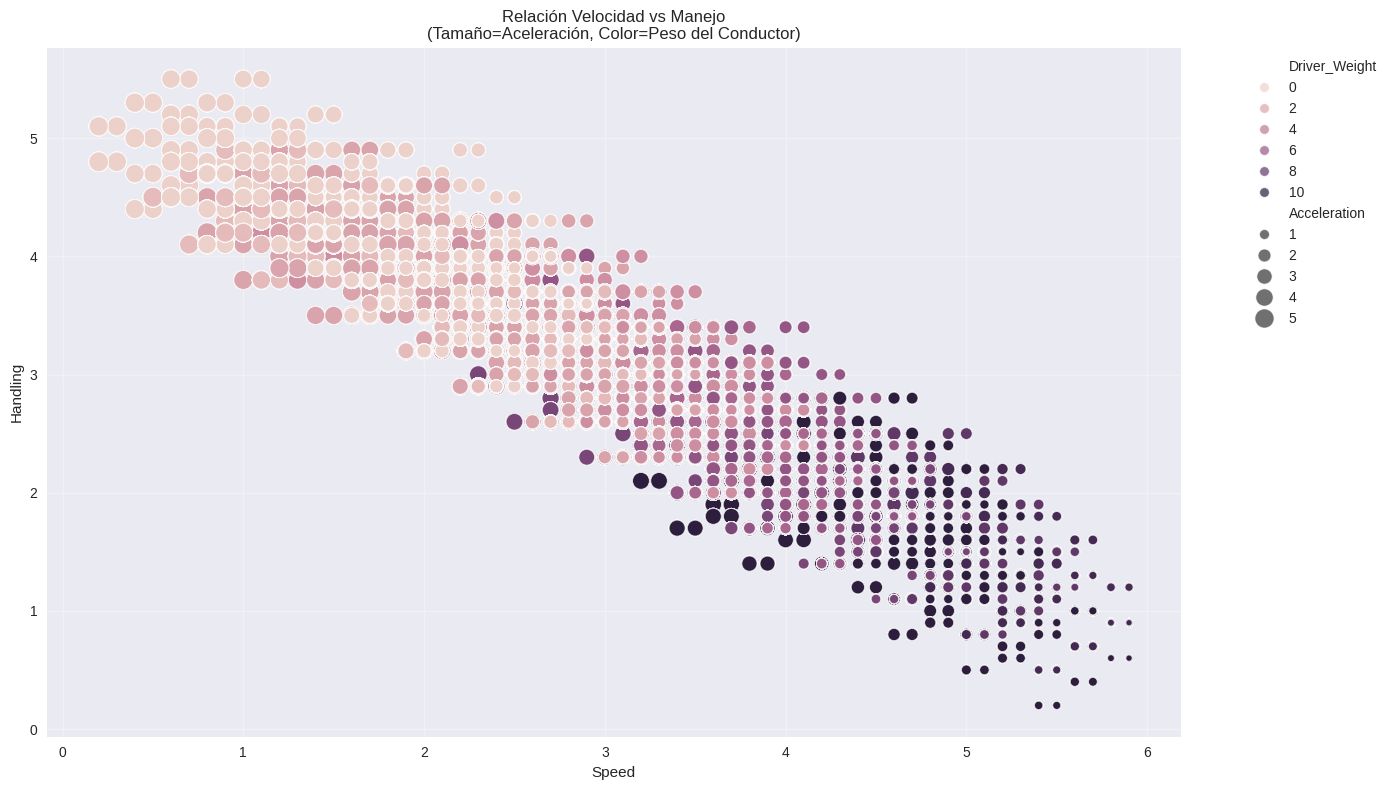


 Top 5 Configuraciones Balanceadas


Body        Driver          Glider  Tire  Speed  Acceleration  \
30107  Varmint  Inkling Girl  Plane Glider    Slim    2.3           4.1   
30117  Varmint  Inkling Girl     Gold Glider  Slim    2.3           4.1   
30127  Varmint  Inkling Girl    Super Glider  Slim    2.3           4.1   
30137  Varmint  Inkling Girl     Hylian Kite  Slim    2.3           4.1   
30167  Varmint  Inkling Girl     Wario Wing   Slim    2.3           4.1   

       Handling  Balance_Score  
30107       4.3           3.44  
30117       4.3           3.44  
30127       4.3           3.44  
30137       4.3           3.44  
30167       4.3           3.44


Datos escalados listos para modelado:
[[-2.36717966  1.93017683  2.39194437 -1.09761227  2.19614498]
 [-2.01492718  1.16819767  2.18286724 -1.19867246  0.96777916]
 [-2.01492718  1.35869246  2.18286724 -0.89549189  0.96777916]
 [-2.36717966  1.54918725  1.76471297 -0.99655208  1.78668971]
 [-2.5433059   1.93017683  2.18286724 -1.09761227  2.60560026]]


In [ ]:
# EDA para los datos originales
print("\n Analisis Exploratorio Datos Originales")
for df, name in zip([bodies_karts_df, drivers_df, gliders_df, tires_df],
                   ['Bodies/Karts', 'Drivers', 'Gliders', 'Tires']):
    comprehensive_eda(df, name)

config_df, scaled_data = prepare_data(bodies_karts_df, drivers_df, gliders_df, tires_df)

analyze_combined_configs(config_df)

# Los datos escalados están disponibles en scaled_data
print("\nDatos escalados listos para modelado:")
print(scaled_data[:5])  # Mostrando solo las primeras 5 filas como ejemplo

### 1.2. Insights Multivariados

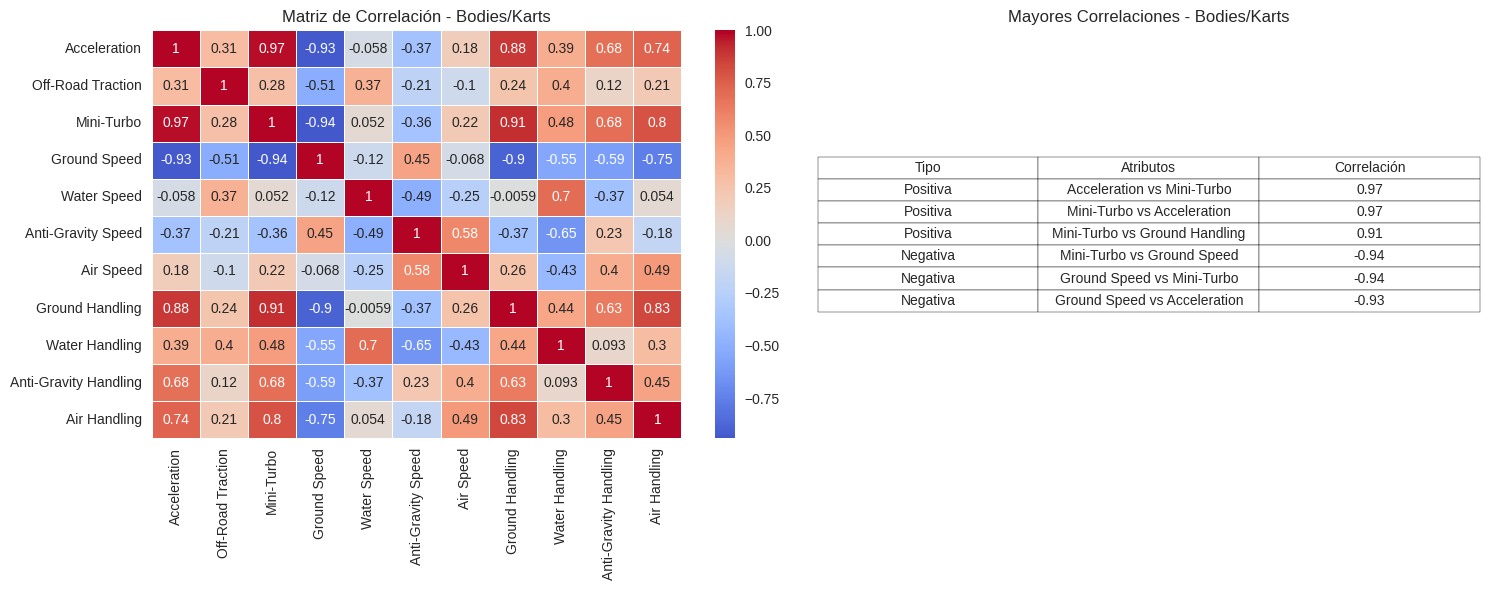


 Análisis para Bodies/Karts:
Top 3 sinergias (valores positivos):
- Acceleration y Mini-Turbo: 0.97 (mejoran juntos)
- Mini-Turbo y Acceleration: 0.97 (mejoran juntos)
- Mini-Turbo y Ground Handling: 0.91 (mejoran juntos)

Top 3 compensaciones (valores negativos):
- Mini-Turbo y Ground Speed: -0.94 (mejorar uno empeora el otro)
- Ground Speed y Mini-Turbo: -0.94 (mejorar uno empeora el otro)
- Ground Speed y Acceleration: -0.93 (mejorar uno empeora el otro)




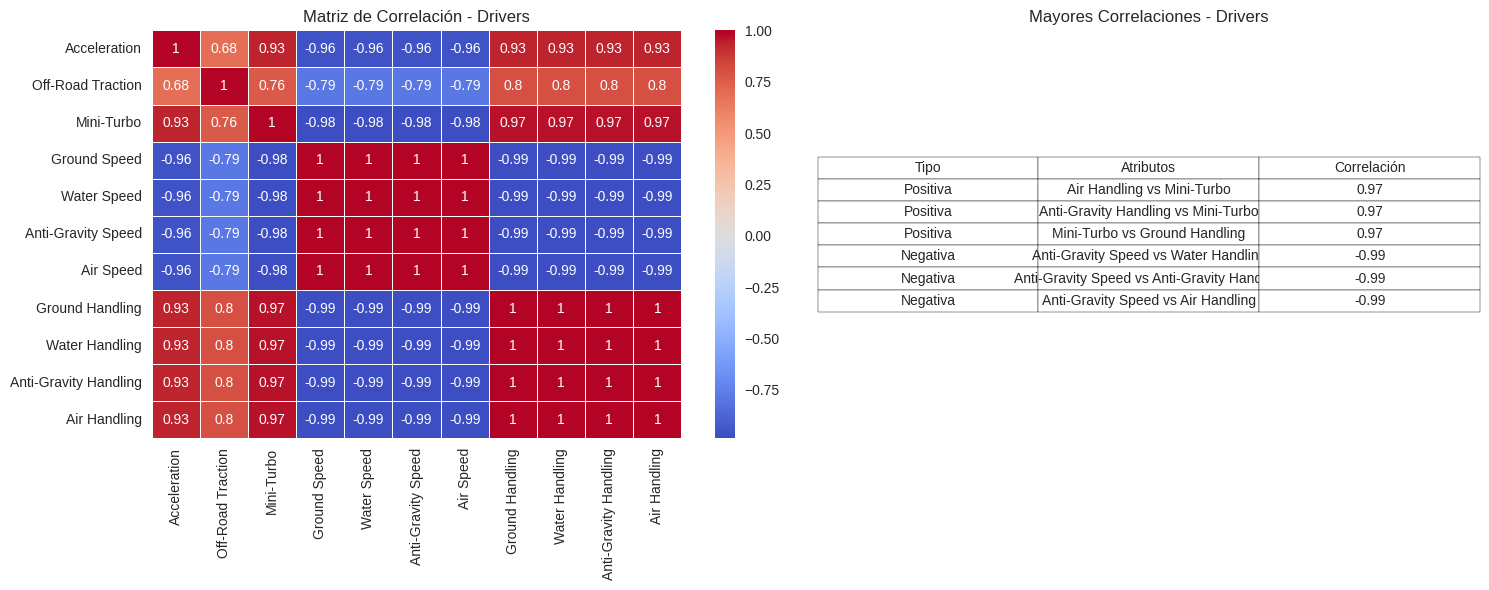


 Análisis para Drivers:
Top 3 sinergias (valores positivos):
- Air Handling y Mini-Turbo: 0.97 (mejoran juntos)
- Anti-Gravity Handling y Mini-Turbo: 0.97 (mejoran juntos)
- Mini-Turbo y Ground Handling: 0.97 (mejoran juntos)

Top 3 compensaciones (valores negativos):
- Anti-Gravity Speed y Water Handling: -0.99 (mejorar uno empeora el otro)
- Anti-Gravity Speed y Anti-Gravity Handling: -0.99 (mejorar uno empeora el otro)
- Anti-Gravity Speed y Air Handling: -0.99 (mejorar uno empeora el otro)




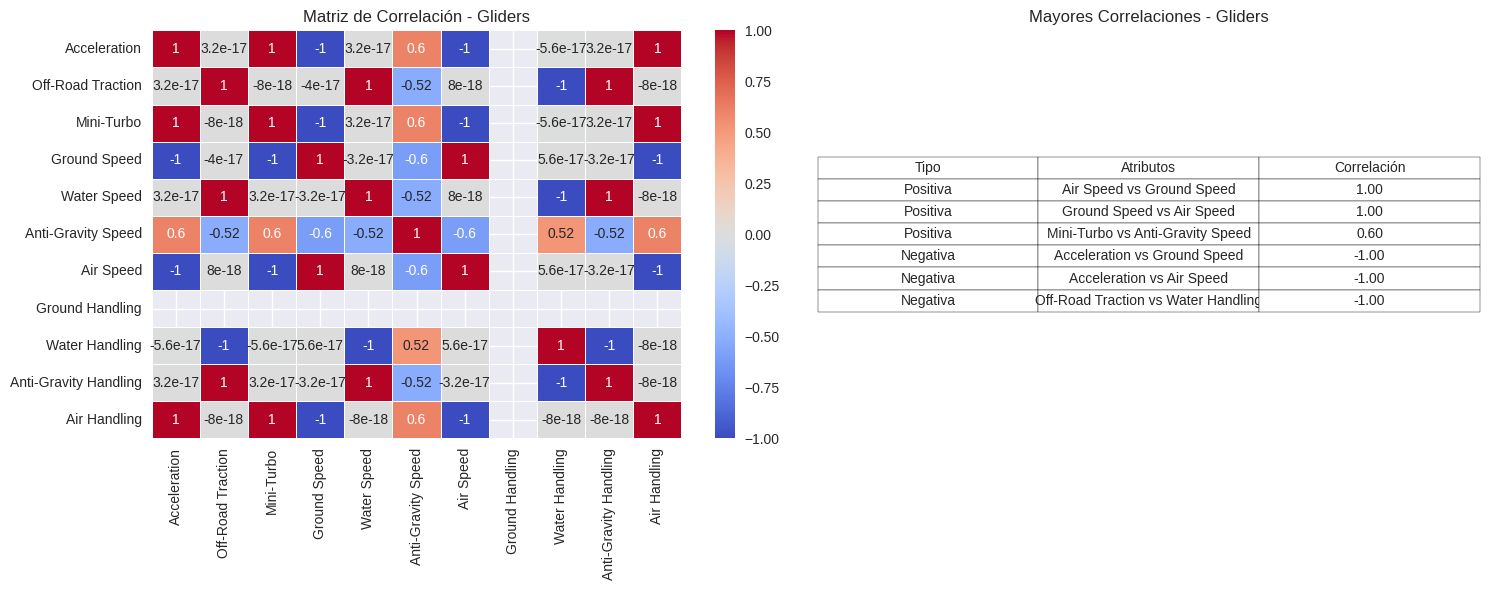


 Análisis para Gliders:
Top 3 sinergias (valores positivos):
- Air Speed y Ground Speed: 1.00 (mejoran juntos)
- Ground Speed y Air Speed: 1.00 (mejoran juntos)
- Mini-Turbo y Anti-Gravity Speed: 0.60 (mejoran juntos)

Top 3 compensaciones (valores negativos):
- Acceleration y Ground Speed: -1.00 (mejorar uno empeora el otro)
- Acceleration y Air Speed: -1.00 (mejorar uno empeora el otro)
- Off-Road Traction y Water Handling: -1.00 (mejorar uno empeora el otro)




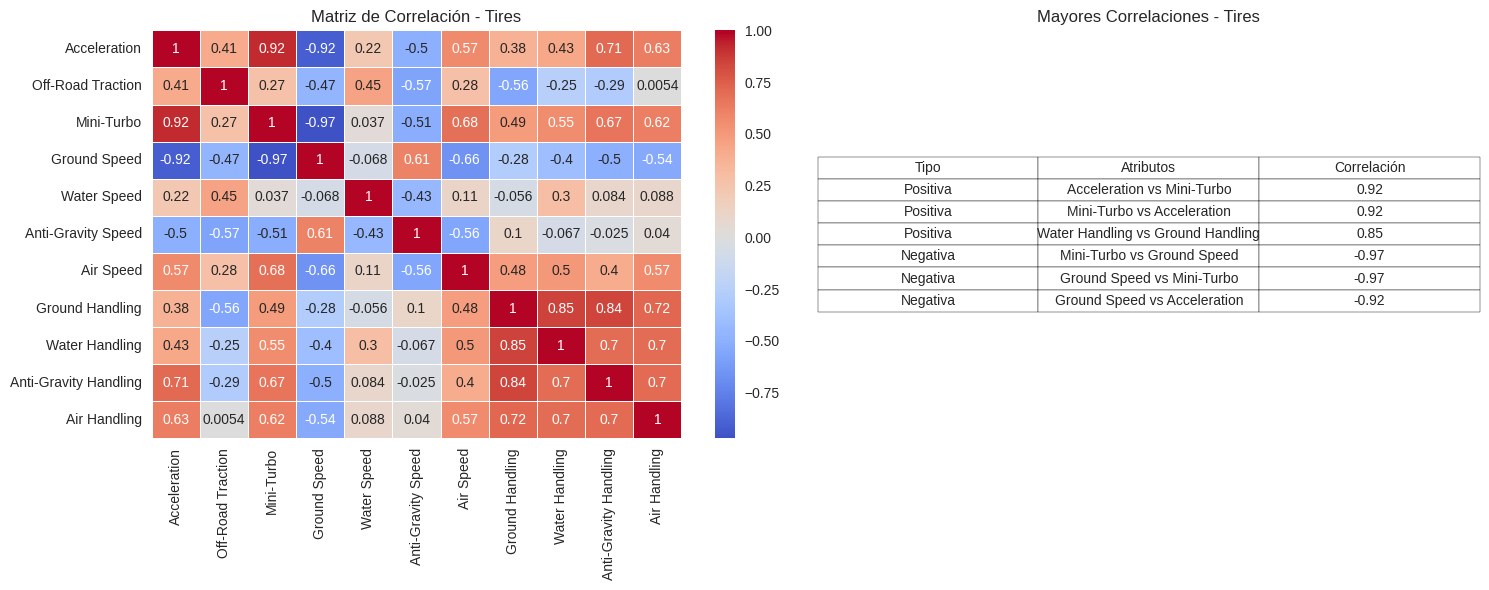


 Análisis para Tires:
Top 3 sinergias (valores positivos):
- Acceleration y Mini-Turbo: 0.92 (mejoran juntos)
- Mini-Turbo y Acceleration: 0.92 (mejoran juntos)
- Water Handling y Ground Handling: 0.85 (mejoran juntos)

Top 3 compensaciones (valores negativos):
- Mini-Turbo y Ground Speed: -0.97 (mejorar uno empeora el otro)
- Ground Speed y Mini-Turbo: -0.97 (mejorar uno empeora el otro)
- Ground Speed y Acceleration: -0.92 (mejorar uno empeora el otro)




In [ ]:
def plot_correlation_analysis():
    for df, name in zip([bodies_karts_df, drivers_df, gliders_df, tires_df],
                       ['Bodies/Karts', 'Drivers', 'Gliders', 'Tires']):
        # Seleccionar solo columnas numéricas relevantes
        numeric_cols = df.select_dtypes(include=np.number).columns
        key_metrics = [col for col in numeric_cols if any(term in col for term in
                       ['Speed', 'Handling', 'Acceleration', 'Traction', 'Mini-Turbo'])]

        # Calcular matriz de correlación
        corr_matrix = df[key_metrics].corr()

        # Crear figura con dos subplots
        plt.figure(figsize=(15, 6))

        # Heatmap de correlación
        plt.subplot(1, 2, 1)
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, linewidths=.5)
        plt.title(f'Matriz de Correlación - {name}')

        # Extraer top y bottom correlaciones
        corr_unstacked = corr_matrix.unstack()
        corr_unstacked = corr_unstacked[corr_unstacked != 1]  # Eliminar autocorrelaciones
        top_3 = corr_unstacked.sort_values(ascending=False).head(3)
        bottom_3 = corr_unstacked.sort_values().head(3)

        # Crear tabla resumen
        summary_data = []
        for idx, val in top_3.items():
            summary_data.append(['Positiva', f"{idx[0]} vs {idx[1]}", f"{val:.2f}"])
        for idx, val in bottom_3.items():
            summary_data.append(['Negativa', f"{idx[0]} vs {idx[1]}", f"{val:.2f}"])

        # Tabla de resumen
        plt.subplot(1, 2, 2)
        plt.axis('off')
        table = plt.table(cellText=summary_data,
                         colLabels=['Tipo', 'Atributos', 'Correlación'],
                         loc='center',
                         cellLoc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1, 1.5)
        plt.title(f'Mayores Correlaciones - {name}')

        plt.tight_layout()
        plt.show()

        # Imprimir interpretación en consola
        print(f"\n Análisis para {name}:")
        print("Top 3 sinergias (valores positivos):")
        for idx, val in top_3.items():
            print(f"- {idx[0]} y {idx[1]}: {val:.2f} (mejoran juntos)")

        print("\nTop 3 compensaciones (valores negativos):")
        for idx, val in bottom_3.items():
            print(f"- {idx[0]} y {idx[1]}: {val:.2f} (mejorar uno empeora el otro)")
        print("\n" + "="*60 + "\n")

plot_correlation_analysis()

### 1.3. Desempeño Componente/Pista

ANÁLISIS COMPLETO POR TIPO DE PISTA


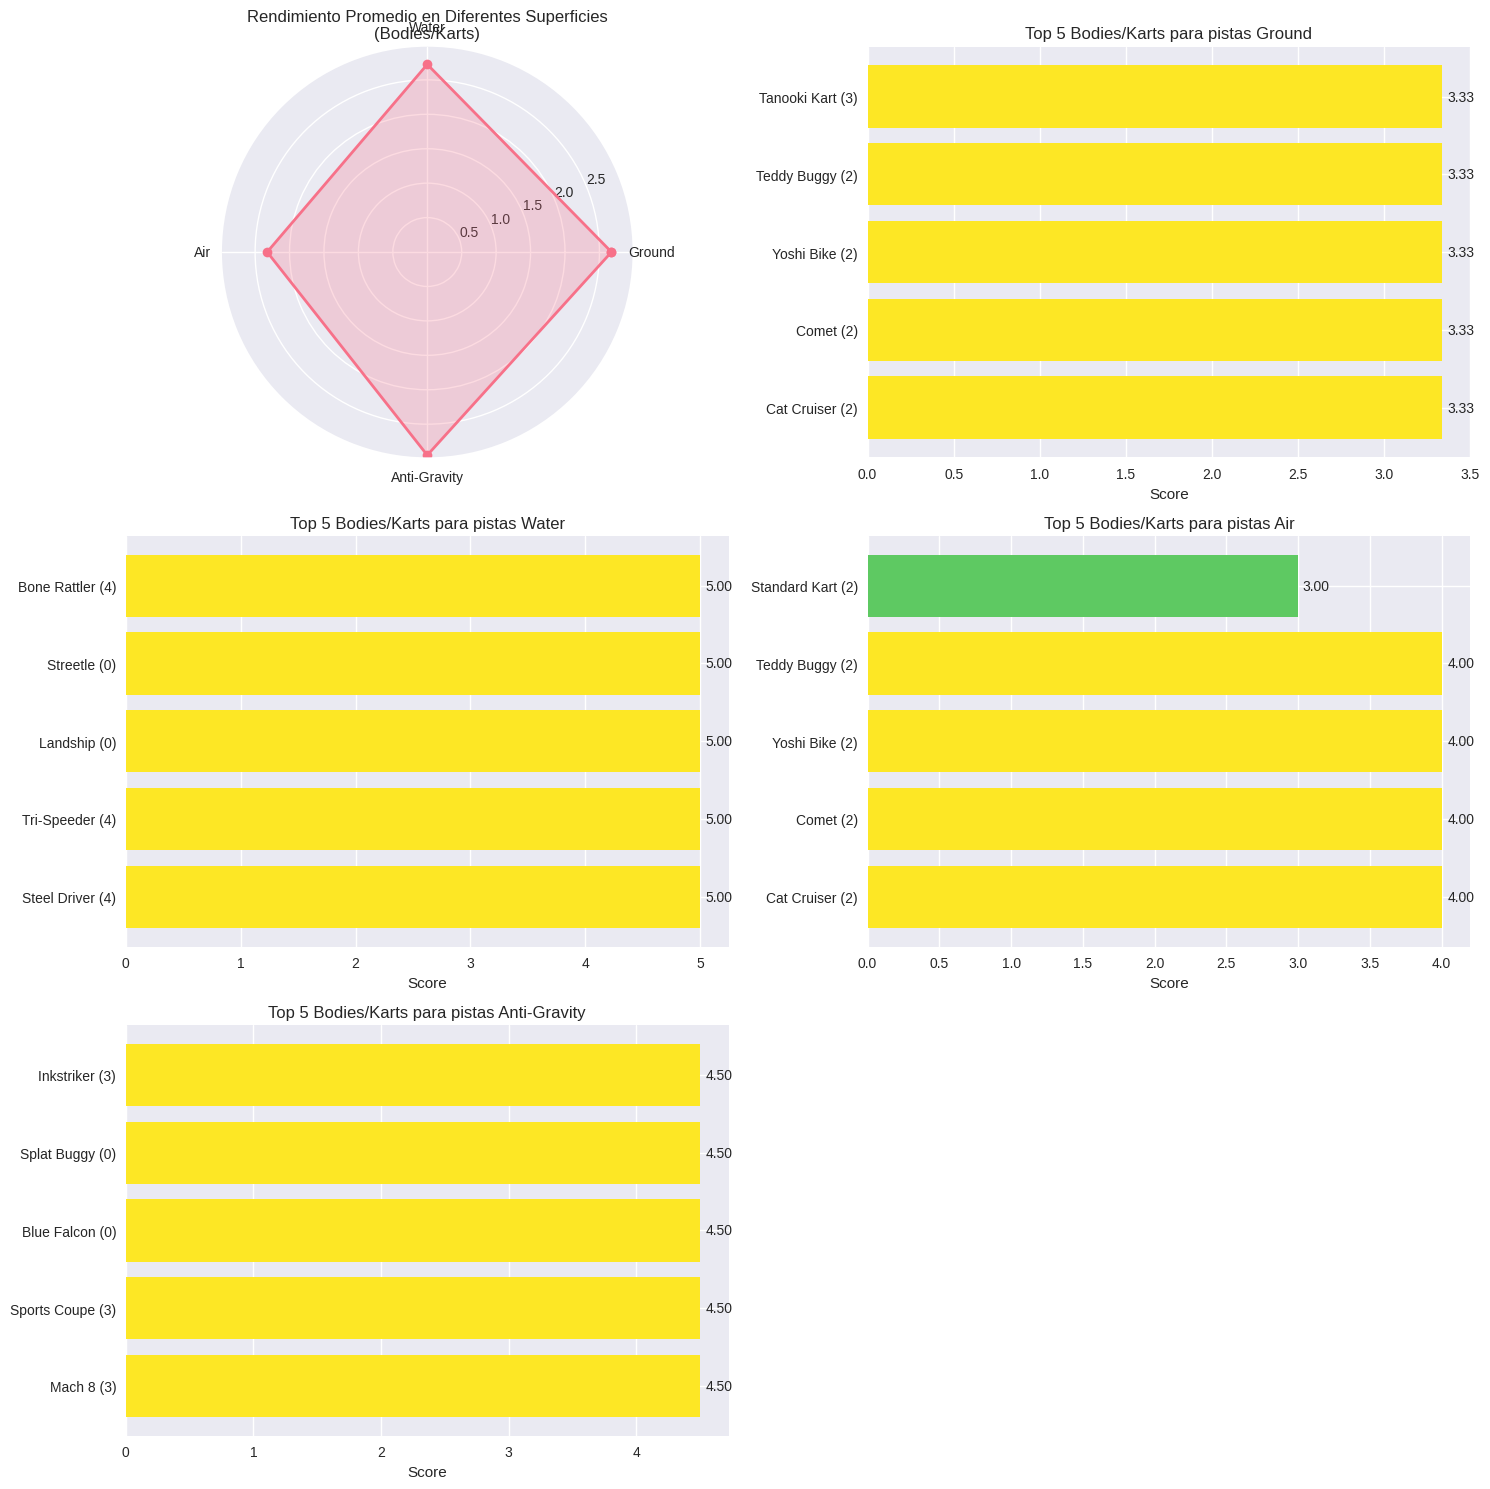


 TOP 5 BODIES/KARTS PARA PISTAS GROUND:



 TOP 5 BODIES/KARTS PARA PISTAS WATER:



 TOP 5 BODIES/KARTS PARA PISTAS AIR:



 TOP 5 BODIES/KARTS PARA PISTAS ANTI-GRAVITY:


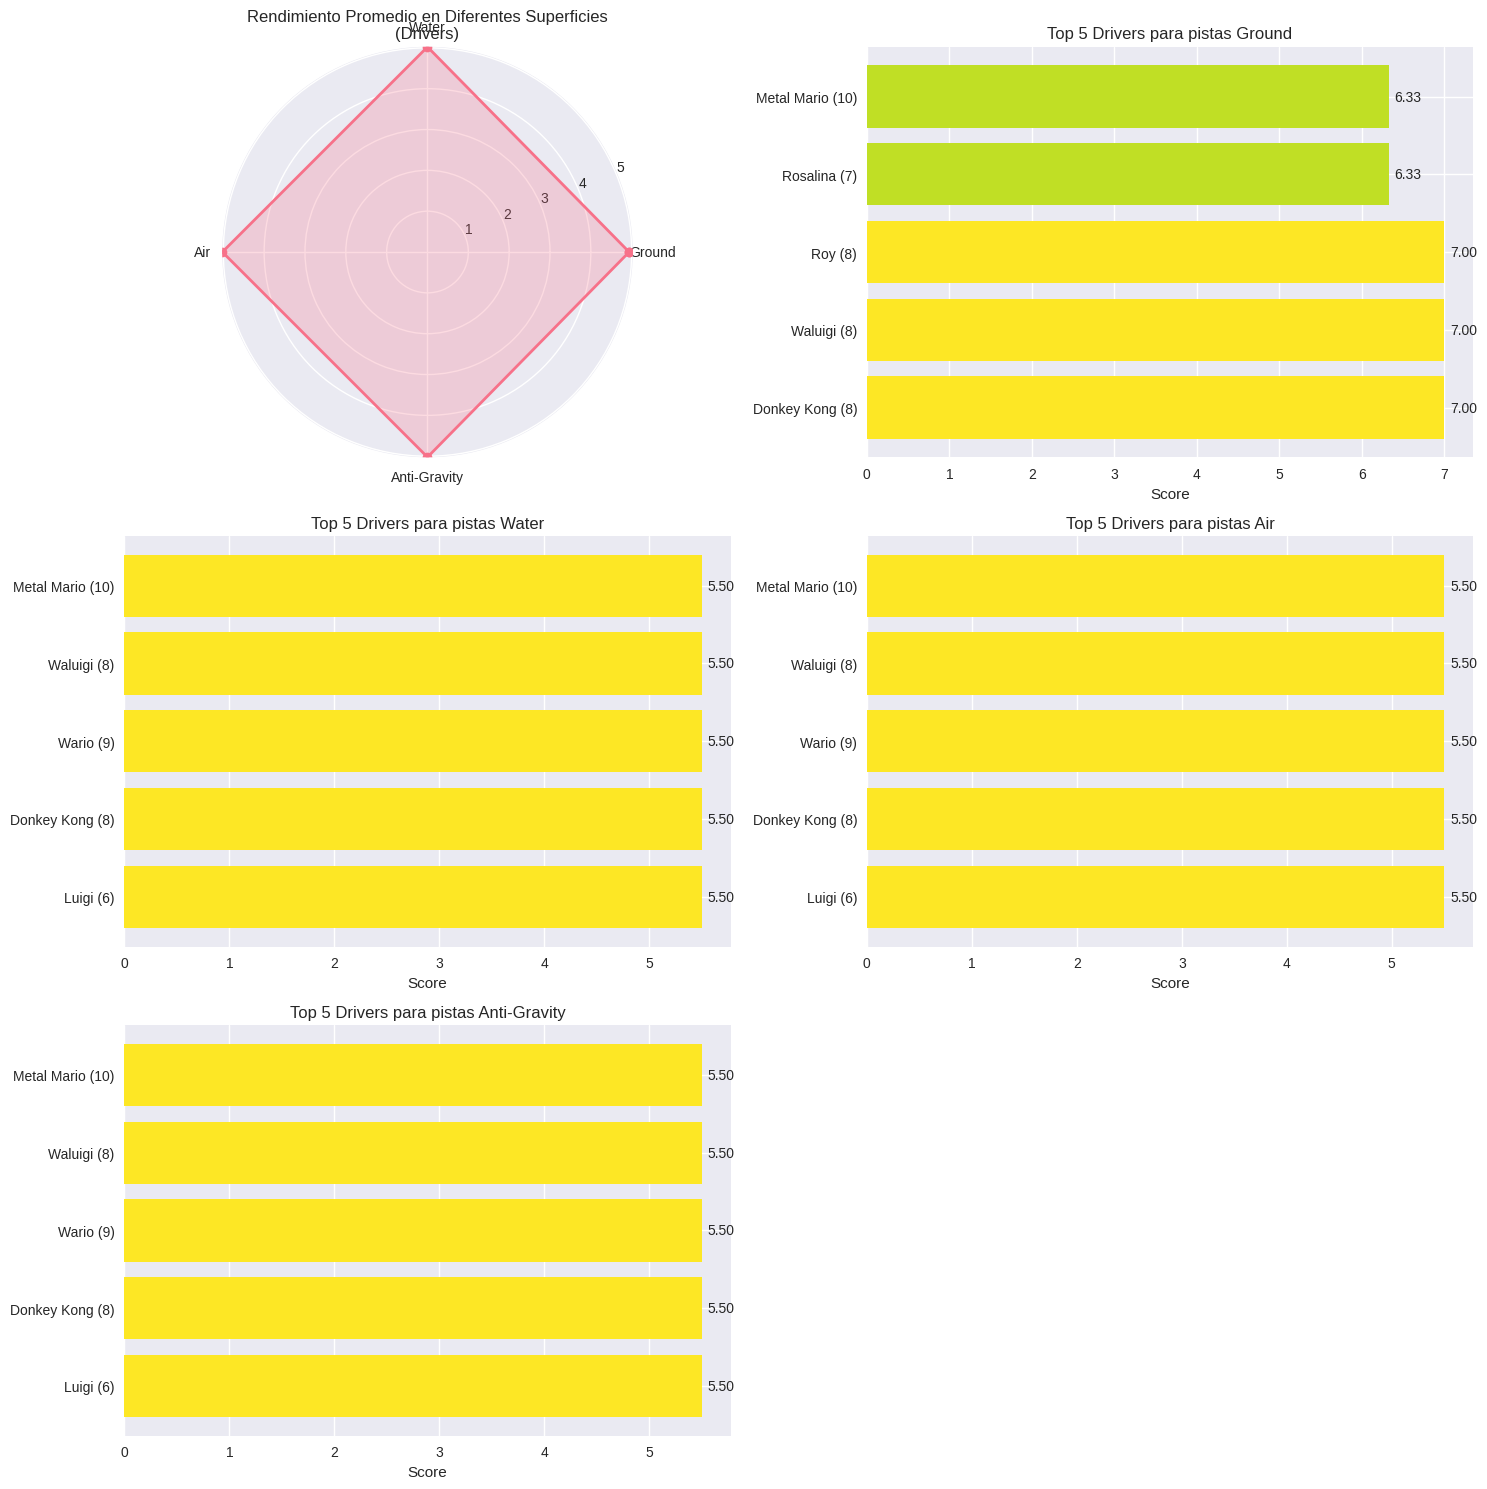


 TOP 5 DRIVERS PARA PISTAS GROUND:



 TOP 5 DRIVERS PARA PISTAS WATER:



 TOP 5 DRIVERS PARA PISTAS AIR:



 TOP 5 DRIVERS PARA PISTAS ANTI-GRAVITY:


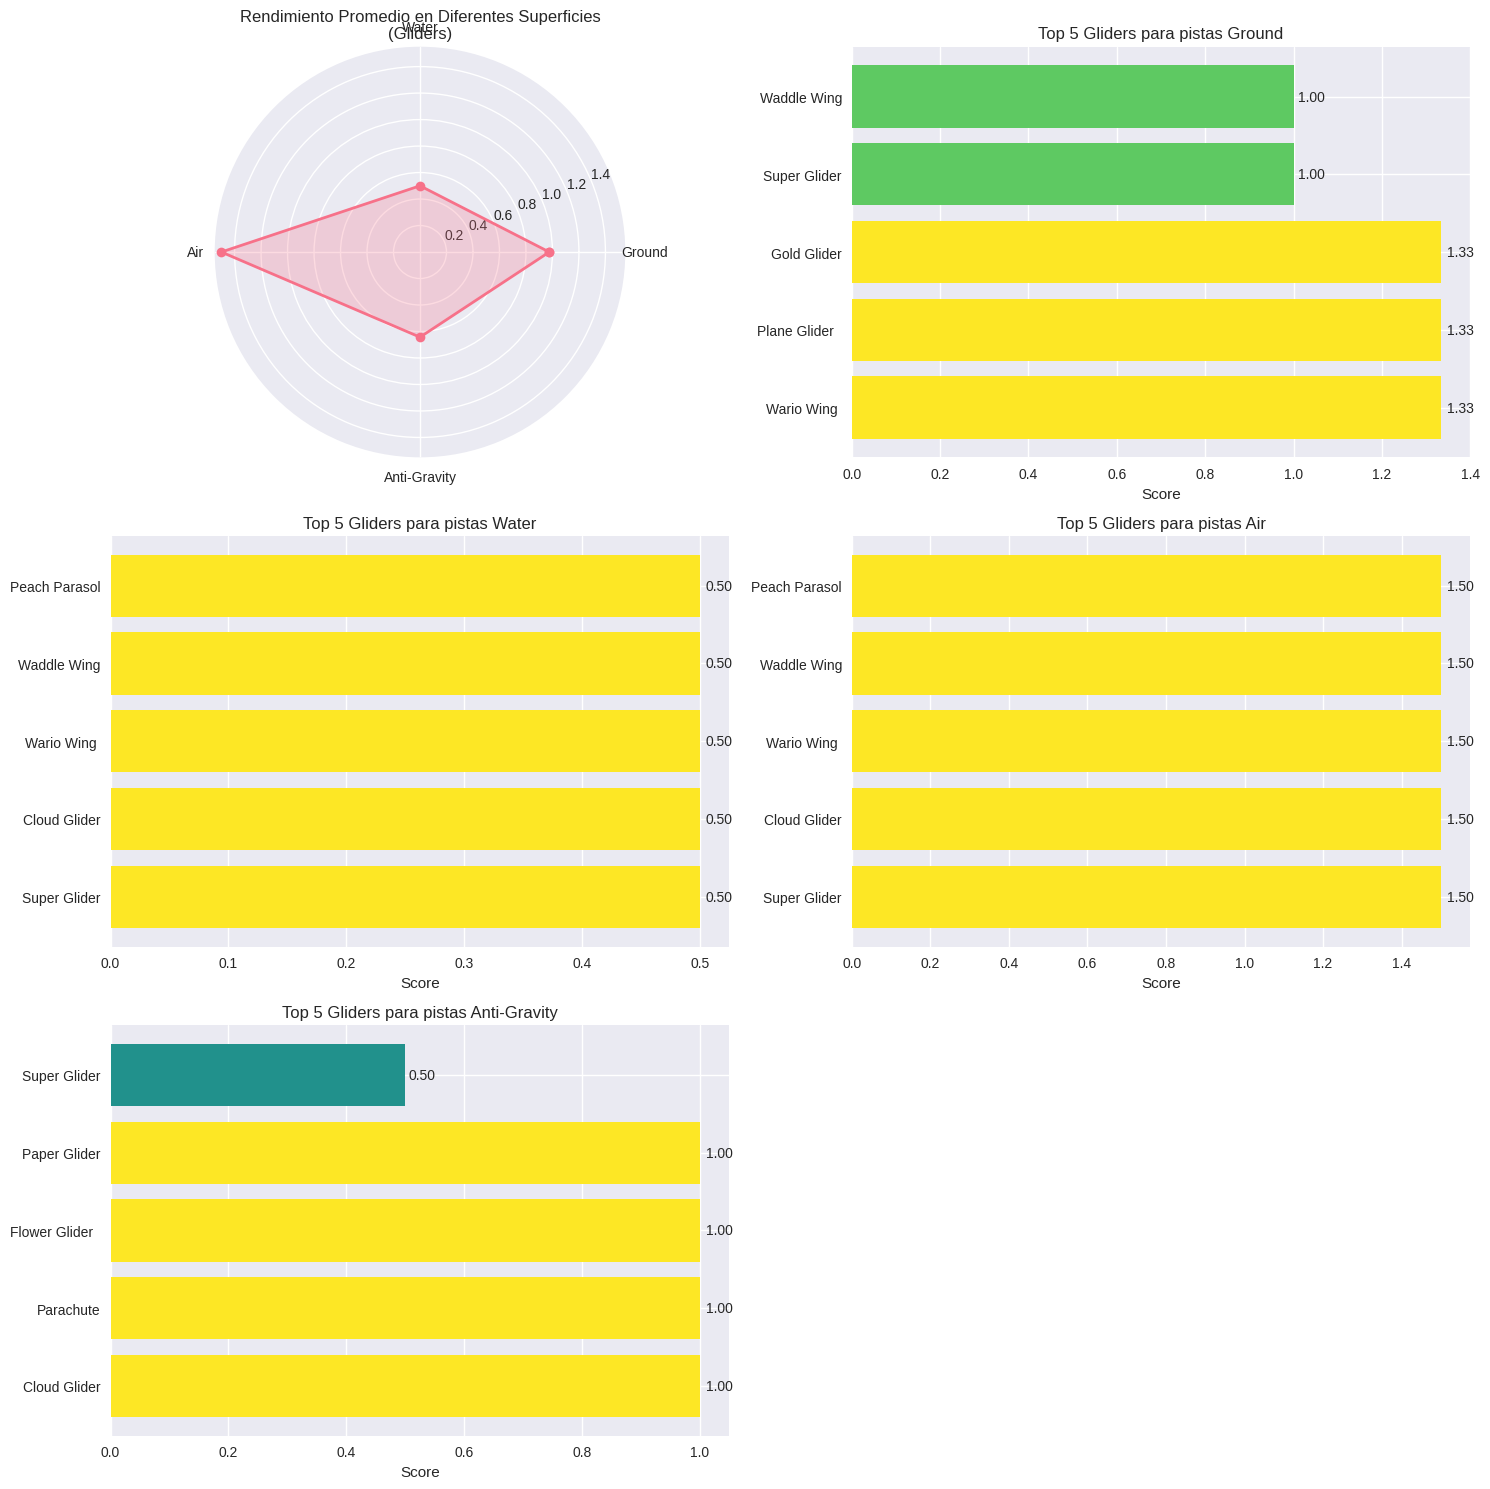


 TOP 5 GLIDERS PARA PISTAS GROUND:



 TOP 5 GLIDERS PARA PISTAS WATER:



 TOP 5 GLIDERS PARA PISTAS AIR:



 TOP 5 GLIDERS PARA PISTAS ANTI-GRAVITY:


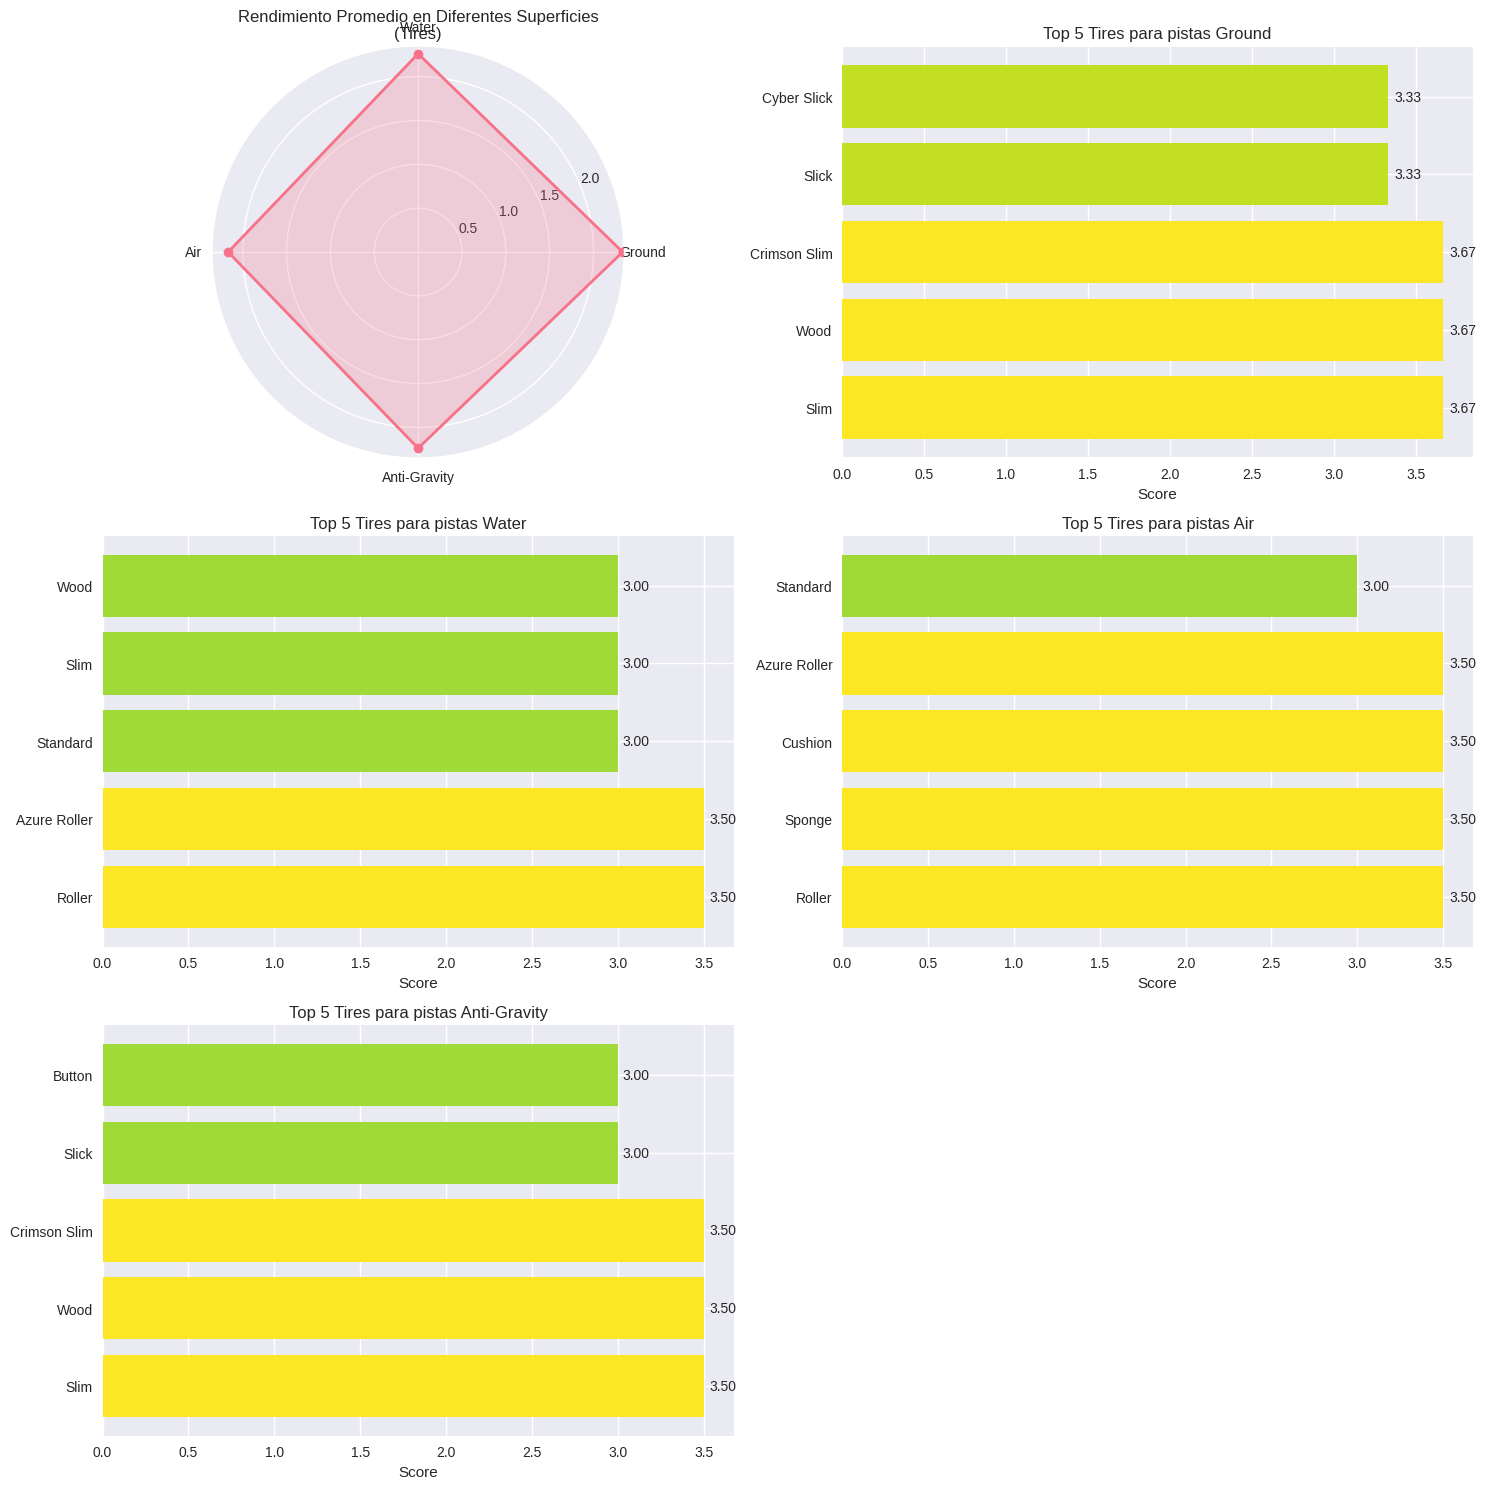


 TOP 5 TIRES PARA PISTAS GROUND:



 TOP 5 TIRES PARA PISTAS WATER:



 TOP 5 TIRES PARA PISTAS AIR:



 TOP 5 TIRES PARA PISTAS ANTI-GRAVITY:


In [ ]:
def analyze_all_track_types(df, component_name):
    """
    Analiza y compara el rendimiento en todos los tipos de pista
    para un componente específico (Bodies/Karts, Drivers, etc.)

    Args:
        df: DataFrame con las estadísticas del componente
        component_name: Nombre del componente para mostrar en los títulos
    """
    # Definir perfiles completos con todas las superficies
    track_profiles = {
        'Ground': ['Ground Speed', 'Ground Handling', 'On-Road traction'],
        'Water': ['Water Speed', 'Water Handling'],
        'Air': ['Air Speed', 'Air Handling'],
        'Anti-Gravity': ['Anti-Gravity Speed', 'Anti-Gravity Handling']
    }

    # Calcular scores para cada tipo de pista
    results = {}
    for track_type, cols in track_profiles.items():
        # Filtrar columnas que existen en el DataFrame
        available_cols = [c for c in cols if c in df.columns]
        if available_cols:  # Solo calcular si hay columnas disponibles
            df[f'{track_type}_Score'] = df[available_cols].mean(axis=1)
            results[track_type] = df.nlargest(5, f'{track_type}_Score')

    # Crear figura con subplots adecuados
    num_plots = len(results) + 1  # +1 para el gráfico de radar
    rows = (num_plots + 1) // 2
    cols = 2 if num_plots > 1 else 1
    fig = plt.figure(figsize=(15, 5 * rows))

    # Gráfico de radar para comparar promedios
    if len(results) > 1:  # Solo hacer radar si hay múltiples superficies
        ax = fig.add_subplot(rows, cols, 1, polar=True)

        stats = []
        categories = []
        for track_type in results.keys():
            stats.append(df[f'{track_type}_Score'].mean())
            categories.append(track_type)

        # Cerrar el círculo
        stats += stats[:1]
        angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False).tolist()
        angles += angles[:1]

        ax.plot(angles, stats, 'o-', linewidth=2)
        ax.fill(angles, stats, alpha=0.25)
        ax.set_thetagrids(np.degrees(angles[:-1]), categories)
        ax.set_title(f'Rendimiento Promedio en Diferentes Superficies\n({component_name})')

    # Mostrar top configuraciones para cada tipo
    for i, (track_type, top_df) in enumerate(results.items(), 2 if len(results) > 1 else 1):
        ax = fig.add_subplot(rows, cols, i)

        # Crear gráfico de barras horizontal para mejor legibilidad
        bars = ax.barh(top_df.index.astype(str), top_df[f'{track_type}_Score'],
                      color=plt.cm.viridis(top_df[f'{track_type}_Score']/top_df[f'{track_type}_Score'].max()))

        ax.set_title(f'Top 5 {component_name} para pistas {track_type}')
        ax.set_xlabel('Score')

        # Añadir etiquetas con los nombres
        labels = []
        for _, row in top_df.iterrows():
            if 'Body' in df.columns:
                label = f"{row['Body']} ({row['Weight']})"
            elif 'Driver' in df.columns:
                label = f"{row['Driver']} ({row['Weight']})"
            elif 'Glider' in df.columns:
                label = row['Glider']
            else:
                label = row['Tire']
            labels.append(label)

        ax.set_yticks(top_df.index.astype(str))
        ax.set_yticklabels(labels)

        # Añadir valores en las barras
        for bar in bars:
            width = bar.get_width()
            ax.text(width * 1.01, bar.get_y() + bar.get_height()/2,
                    f'{width:.2f}', va='center')

    plt.tight_layout()
    plt.show()

    # Mostrar tablas detalladas en consola
    for track_type, top_df in results.items():
        print(f"\n TOP 5 {component_name.upper()} PARA PISTAS {track_type.upper()}:")
        display_cols = [c for c in ['Body', 'Driver', 'Glider', 'Tire', 'Weight'] if c in top_df.columns]
        display_cols += [c for c in top_df.columns if track_type in c and 'Score' not in c]
        display_cols += [f'{track_type}_Score']

        display(top_df[display_cols].sort_values(f'{track_type}_Score', ascending=False)
                .style.background_gradient(cmap='viridis', subset=[f'{track_type}_Score']))

# Ejemplo de uso para cada componente
print("="*80)
print("ANÁLISIS COMPLETO POR TIPO DE PISTA")
print("="*80)

analyze_all_track_types(bodies_karts_df, "Bodies/Karts")
analyze_all_track_types(drivers_df, "Drivers")
analyze_all_track_types(gliders_df, "Gliders")
analyze_all_track_types(tires_df, "Tires")

### 1.4. Combinaciones optimas en base a analisis estadistioc

In [ ]:
def find_optimal_combinations(config_df):
    # Normalizar métricas
    metrics = ['Speed', 'Acceleration', 'Handling', 'Traction', 'Mini-Turbo']
    config_df_norm = config_df.copy()
    config_df_norm[metrics] = config_df_norm[metrics].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

    # Crear scores personalizados
    config_df_norm['Balanced'] = config_df_norm[metrics].mean(axis=1)
    config_df_norm['Speed_Focused'] = config_df_norm['Speed']*0.6 + config_df_norm['Handling']*0.4
    config_df_norm['Technical'] = config_df_norm['Handling']*0.5 + config_df_norm['Acceleration']*0.5

    return config_df_norm.sort_values('Balanced', ascending=False).head(3)

optimal_combinations = find_optimal_combinations(config_df)
display(optimal_combinations[['Body', 'Driver', 'Glider', 'Tire', 'Balanced', 'Speed_Focused', 'Technical']])

Body         Driver         Glider           Tire  Balanced  \
29098  Varmint  Baby Rosalina  Peach Parasol      GLA Tires  0.665505   
29096  Varmint  Baby Rosalina  Peach Parasol  Blue Standard  0.665505   
29090  Varmint  Baby Rosalina  Peach Parasol       Standard  0.665505   

       Speed_Focused  Technical  
29098       0.425422   0.914369  
29096       0.425422   0.914369  
29090       0.425422   0.914369

## Parte 2. Analisis topologico

### 2.1. Analisis topologivo con Kmapper

In [ ]:
def build_mapper_graph(data, config_df, n_cubes=10, overlap=0.3):
    """Construye gráfico Mapper para análisis topológico"""
    mapper = km.KeplerMapper(verbose=1)

    # Reducción de dimensionalidad
    pca = PCA(n_components=2)
    projected_data = pca.fit_transform(data)

    # Construcción del grafo
    graph = mapper.map(
        projected_data,
        data,
        cover=km.Cover(n_cubes=n_cubes, perc_overlap=overlap),
        clusterer=KMeans(n_clusters=3, random_state=42)
    )

    # Visualización interactiva
    html = mapper.visualize(
        graph,
        path_html="mario_kart_mapper.html",
        title="Topología de Configuraciones",
        custom_tooltips=config_df.apply(lambda x: f"{x['Body']}|{x['Driver']}|{x['Glider']}|{x['Tire']}", axis=1)
    )

    return graph

# Construir grafo Mapper
mapper_graph = build_mapper_graph(scaled_data, config_df)

KeplerMapper(verbose=1)
Mapping on data shaped (102500, 5) using lens shaped (102500, 2)

Creating 100 hypercubes.


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning:

Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning:

Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning:

Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.




Created 982 edges and 263 nodes in 0:00:03.199176.
Wrote visualization to: mario_kart_mapper.html


#### 2.1.1. Datos especificos a clusters

In [ ]:
def get_mapper_cluster_stats(mapper_graph, config_df):

    # Crear matriz de asignación
    n_samples = len(config_df)
    n_nodes = len(mapper_graph['nodes'])
    assignment_matrix = np.zeros((n_samples, n_nodes), dtype=int)

    # Diccionario para mapear nombres de nodos a índices numéricos
    node_index_map = {node_name: idx for idx, node_name in enumerate(mapper_graph['nodes'].keys())}

    # Asignar cada punto a sus nodos
    for node_name, members in mapper_graph['nodes'].items():
        assignment_matrix[members, node_index_map[node_name]] = 1

    # Calcular estadísticas por nodo
    stats = []
    for node_name, members in mapper_graph['nodes'].items():
        node_data = config_df.iloc[members]
        stats.append({
            'node_id': node_name,
            'size': len(members),
            'speed_mean': node_data['Speed'].mean(),
            'accel_mean': node_data['Acceleration'].mean(),
            'handling_mean': node_data['Handling'].mean(),
            'traction_mean': node_data['Traction'].mean(),
            'mini_turbo_mean': node_data['Mini-Turbo'].mean(),
            'balance_score_mean': node_data['Balance_Score'].mean(),
            'pca1_mean': node_data['pca1'].mean() if 'pca1' in config_df else np.nan,
            'pca2_mean': node_data['pca2'].mean() if 'pca2' in config_df else np.nan
        })

    return pd.DataFrame(stats), assignment_matrix

In [ ]:
#Componentes PCA
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_data)
config_df['pca1'] = pca_components[:, 0]
config_df['pca2'] = pca_components[:, 1]

# Obtener estadísticas
node_stats_df, assignment_matrix = get_mapper_cluster_stats(mapper_graph, config_df)

# Mostrar los nodos más importantes
print("Nodos ordenados por tamaño:")
display(node_stats_df.sort_values('size', ascending=False).head())

print("\n Nodos ordenados por balance score:")
display(node_stats_df.sort_values('balance_score_mean', ascending=False).head())

Nodos ordenados por tamaño:


node_id  size  speed_mean  accel_mean  handling_mean  \
107  cube36_cluster1  3474    2.630455    3.029850       3.464680   
136  cube46_cluster0  2781    3.390651    2.315822       3.060626   
83   cube28_cluster1  2673    2.182566    3.631238       4.081407   
137  cube46_cluster1  2659    3.509741    2.407146       2.634524   
76   cube26_cluster0  2582    2.200349    3.043300       3.732881   

     traction_mean  mini_turbo_mean  balance_score_mean  pca1_mean  pca2_mean  
107       2.189609         2.572769            3.000541  -0.850189  -0.554328  
136       2.649227         1.906365            2.969195   0.563277  -0.535434  
83        2.955032         2.667340            3.186820  -1.482500   0.359369  
137       2.438473         2.345468            2.916397   0.449455  -0.564433  
76        2.027188         3.040860            2.912994  -1.528561  -0.561735


 Nodos ordenados por balance score:


node_id  size  speed_mean  accel_mean  handling_mean  \
156  cube52_cluster2   210    3.628571    3.285714       3.014286   
66   cube22_cluster0   102    2.288235    4.288235       3.776471   
184  cube62_cluster0   210    4.014286    3.071429       2.674286   
91   cube31_cluster0   270    2.322222    4.211111       3.777778   
213  cube71_cluster2    45    4.600000    2.400000       2.500000   

     traction_mean  mini_turbo_mean  balance_score_mean  pca1_mean  pca2_mean  
156       5.025714         2.514286            3.341429   0.507121   2.160710  
66        3.935294         3.411765            3.334706  -1.791946   1.703239  
184       5.402857         2.348571            3.329429   1.153601   2.402662  
91        3.971111         3.344444            3.325556  -1.690019   1.693069  
213       5.060000         1.900000            3.310000   1.998353   1.752022

In [ ]:
def calculate_node_overlap(mapper_graph):
    """Calcula la matriz de superposición entre nodos"""
    nodes = list(mapper_graph['nodes'].keys())
    n_nodes = len(nodes)
    overlap_matrix = np.zeros((n_nodes, n_nodes))

    for i, node_i in enumerate(nodes):
        for j, node_j in enumerate(nodes):
            set_i = set(mapper_graph['nodes'][node_i])
            set_j = set(mapper_graph['nodes'][node_j])
            overlap_matrix[i,j] = len(set_i & set_j) / len(set_i | set_j) if (set_i | set_j) else 0

    return pd.DataFrame(overlap_matrix, index=nodes, columns=nodes)

# Calcular superposición
overlap_df = calculate_node_overlap(mapper_graph)

print("\n Matriz de superposición entre nodos (primeras 5 filas/columnas):")
display(overlap_df.iloc[:5, :5])


 Matriz de superposición entre nodos (primeras 5 filas/columnas):


cube0_cluster0  cube0_cluster1  cube0_cluster2  \
cube0_cluster0        1.000000             0.0        0.000000   
cube0_cluster1        0.000000             1.0        0.000000   
cube0_cluster2        0.000000             0.0        1.000000   
cube1_cluster0        0.000000             0.0        0.000000   
cube1_cluster1        0.307692             0.0        0.046154   

                cube1_cluster0  cube1_cluster1  
cube0_cluster0             0.0        0.307692  
cube0_cluster1             0.0        0.000000  
cube0_cluster2             0.0        0.046154  
cube1_cluster0             1.0        0.000000  
cube1_cluster1             0.0        1.000000

In [ ]:
def get_global_cluster_stats(node_stats_df):
    """Calcula estadísticas globales del agrupamiento"""
    return {
        'total_nodes': len(node_stats_df),
        'avg_cluster_size': node_stats_df['size'].mean(),
        'max_cluster_size': node_stats_df['size'].max(),
        'min_cluster_size': node_stats_df['size'].min(),
        'avg_balance_score': node_stats_df['balance_score_mean'].mean(),
        'most_balanced_node': node_stats_df.loc[node_stats_df['balance_score_mean'].idxmax(), 'node_id'],
        'avg_speed': node_stats_df['speed_mean'].mean(),
        'avg_handling': node_stats_df['handling_mean'].mean()
    }

global_stats = get_global_cluster_stats(node_stats_df)
print("\n Estadísticas Globales del Agrupamiento:")
display(pd.Series(global_stats))


 Estadísticas Globales del Agrupamiento:


total_nodes                       263
avg_cluster_size           808.193916
max_cluster_size                 3474
min_cluster_size                    8
avg_balance_score            3.033797
most_balanced_node    cube52_cluster2
avg_speed                    3.266525
avg_handling                 2.935816
dtype: object

In [ ]:
# Exportar estadísticas de nodos
node_stats_df.to_csv('mapper_node_stats.csv', index=False)

# Exportar matriz de asignación
np.savetxt('mapper_assignment_matrix.csv', assignment_matrix, delimiter=',', fmt='%d')


 Estadísticas Resumen por Nodo:


node_id  size  avg_speed  avg_acceleration  avg_handling  \
156  cube52_cluster2   210   3.628571          3.285714      3.014286   
66   cube22_cluster0   102   2.288235          4.288235      3.776471   
184  cube62_cluster0   210   4.014286          3.071429      2.674286   
91   cube31_cluster0   270   2.322222          4.211111      3.777778   
213  cube71_cluster2    45   4.600000          2.400000      2.500000   

     avg_traction  avg_mini_turbo  avg_balance_score  unique_bodies  \
156      5.025714        2.514286           3.341429              4   
66       3.935294        3.411765           3.334706              2   
184      5.402857        2.348571           3.329429              4   
91       3.971111        3.344444           3.325556              2   
213      5.060000        1.900000           3.310000              3   

     unique_drivers  unique_gliders  unique_tires  \
156               6              10             4   
66                3               7             4   
184               6              10             5   
91                3              10             5   
213               3               5             1   

                                            top_config  
156  {'Body': 'Varmint', 'Driver': 'Donkey Kong', '...  
66   {'Body': 'Varmint', 'Driver': 'Tanooki Mario',...  
184  {'Body': 'Cat Cruiser', 'Driver': 'Donkey Kong...  
91   {'Body': 'Varmint', 'Driver': 'Tanooki Mario',...  
213  {'Body': '300 SL Roadster', 'Driver': 'Donkey ...

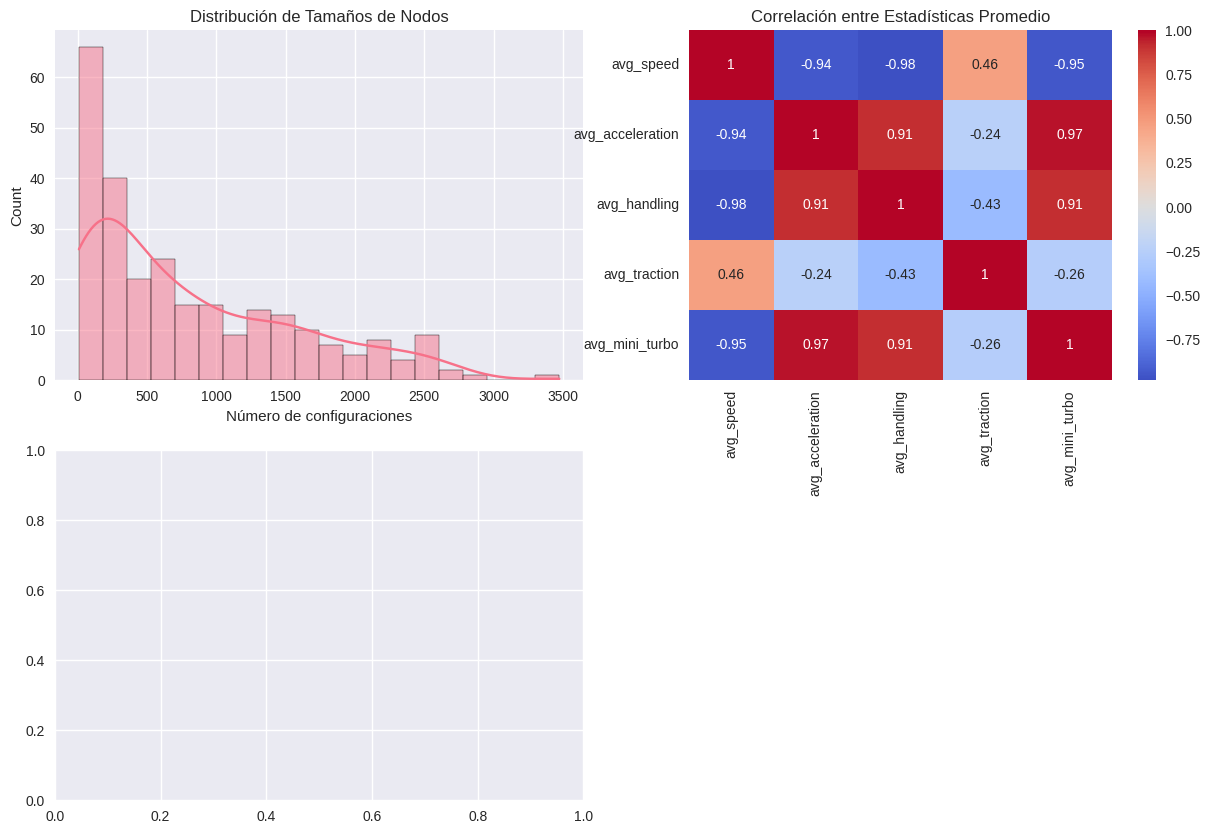

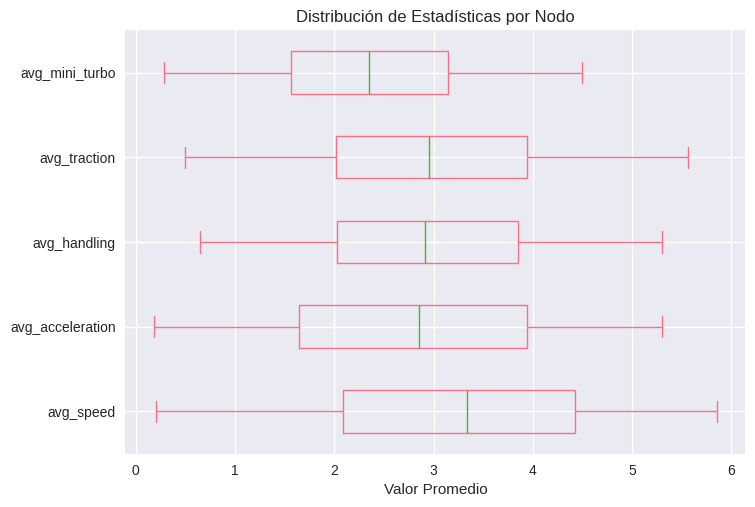

In [ ]:
def analyze_mapper_nodes(mapper_graph, config_df):

    # estructura para almacenar estadísticas
    node_stats = []

    # estadísticas para cada nodo
    for node_id, member_indices in mapper_graph['nodes'].items():
        node_data = config_df.iloc[member_indices]

        stats = {
            'node_id': node_id,
            'size': len(member_indices),
            'avg_speed': node_data['Speed'].mean(),
            'avg_acceleration': node_data['Acceleration'].mean(),
            'avg_handling': node_data['Handling'].mean(),
            'avg_traction': node_data['Traction'].mean(),
            'avg_mini_turbo': node_data['Mini-Turbo'].mean(),
            'avg_balance_score': node_data['Balance_Score'].mean(),
            'unique_bodies': node_data['Body'].nunique(),
            'unique_drivers': node_data['Driver'].nunique(),
            'unique_gliders': node_data['Glider'].nunique(),
            'unique_tires': node_data['Tire'].nunique(),
            'top_config': node_data.loc[node_data['Balance_Score'].idxmax()][['Body', 'Driver', 'Glider', 'Tire']].to_dict()
        }
        node_stats.append(stats)

    # Convertir a DataFrame
    stats_df = pd.DataFrame(node_stats)

    # 3. Visualización de estadísticas clave
    plt.figure(figsize=(15, 10))

    # Distribución de tamaños de nodos
    plt.subplot(2, 2, 1)
    sns.histplot(stats_df['size'], bins=20, kde=True)
    plt.title('Distribución de Tamaños de Nodos')
    plt.xlabel('Número de configuraciones')

    # Heatmap de correlación entre estadísticas
    plt.subplot(2, 2, 2)
    numeric_cols = ['avg_speed', 'avg_acceleration', 'avg_handling', 'avg_traction', 'avg_mini_turbo']
    sns.heatmap(stats_df[numeric_cols].corr(), annot=True, cmap='coolwarm', center=0)
    plt.title('Correlación entre Estadísticas Promedio')

    # Boxplot de estadísticas por nodo
    plt.subplot(2, 2, 3)
    stats_df[numeric_cols].plot(kind='box', vert=False)
    plt.title('Distribución de Estadísticas por Nodo')
    plt.xlabel('Valor Promedio')



    # 4. Mostrar tabla resumen
    print("\n Estadísticas Resumen por Nodo:")
    display(stats_df.sort_values('avg_balance_score', ascending=False).head())

    return stats_df

# Uso: analizar los nodos del grafo Mapper
node_stats = analyze_mapper_nodes(mapper_graph, config_df)

In [ ]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import pandas as pd
import numpy as np

def analyze_mapper_nodes(mapper_graph, config_df, top_n=5):

    # 1. Extraer información de los nodos
    nodes_info = []
    for node_id, member_indices in mapper_graph['nodes'].items():
        # Obtener configuraciones en este nodo
        node_configs = config_df.iloc[member_indices]

        # Calcular estadísticas del nodo
        mean_stats = node_configs[['Speed', 'Acceleration', 'Handling', 'Traction', 'Mini-Turbo']].mean()
        balance_score = node_configs['Balance_Score'].mean()
        size = len(member_indices)

        # Contar componentes únicos
        unique_components = {
            'n_bodies': node_configs['Body'].nunique(),
            'n_drivers': node_configs['Driver'].nunique(),
            'n_gliders': node_configs['Glider'].nunique(),
            'n_tires': node_configs['Tire'].nunique()
        }

        # Ejemplo representativo (el más balanceado del nodo)
        example_config = node_configs.loc[node_configs['Balance_Score'].idxmax()]

        nodes_info.append({
            'node_id': node_id,
            'size': size,
            'balance_score': balance_score,
            'mean_speed': mean_stats['Speed'],
            'mean_accel': mean_stats['Acceleration'],
            'mean_handling': mean_stats['Handling'],
            'mean_traction': mean_stats['Traction'],
            'mean_turbo': mean_stats['Mini-Turbo'],
            **unique_components,
            'example_body': example_config['Body'],
            'example_driver': example_config['Driver'],
            'example_glider': example_config['Glider'],
            'example_tire': example_config['Tire']
        })

    nodes_df = pd.DataFrame(nodes_info)

    # 2. Identificar nodos más balanceados
    balanced_nodes = nodes_df.nlargest(top_n, 'balance_score')

    # 3. Visualización interactiva
    fig = make_subplots(
        rows=1, cols=top_n,
        specs=[[{'type': 'polar'}]*top_n],
        subplot_titles=[f"Nodo {row['node_id']}" for _, row in balanced_nodes.iterrows()]
    )

    for i, (_, node) in enumerate(balanced_nodes.iterrows(), 1):
        fig.add_trace(
            go.Scatterpolar(
                r=[node['mean_speed'], node['mean_accel'], node['mean_handling'],
                   node['mean_traction'], node['mean_turbo'], node['mean_speed']],
                theta=['Velocidad', 'Aceleración', 'Manejo', 'Tracción', 'Mini-Turbo', 'Velocidad'],
                fill='toself',
                name=f"{node['example_body']}/{node['example_driver']}<br>Score: {node['balance_score']:.2f}"
            ),
            row=1, col=i
        )

    fig.update_layout(
        title=f"Top {top_n} Nodos Más Balanceados - Gráficos de Telaraña",
        showlegend=True,
        polar=dict(
            radialaxis=dict(
                visible=True,
                range=[0, max(nodes_df[['mean_speed', 'mean_accel', 'mean_handling',
                                      'mean_traction', 'mean_turbo']].max()) + 0.5]
            )
        ),
        height=500,
        width=300 * top_n
    )

    fig.show()

    # 4. Análisis adicional de los nodos
    print("\n Información Detallada de Nodos Balanceados:")
    for _, node in balanced_nodes.iterrows():
        print(f"\nNodo {node['node_id']} (Score: {node['balance_score']:.2f})")
        print(f"• Tamaño: {node['size']} configuraciones")
        print(f"• Componentes únicos: {node['n_bodies']} bodies, {node['n_drivers']} drivers")
        print(f"• Ejemplo representativo:")
        print(f"  - Body: {node['example_body']}")
        print(f"  - Driver: {node['example_driver']}")
        print(f"  - Glider: {node['example_glider']}")
        print(f"  - Tire: {node['example_tire']}")

    return nodes_df

# Uso con grafo Mapper
nodes_df = analyze_mapper_nodes(mapper_graph, config_df, top_n=3)


 Información Detallada de Nodos Balanceados:

Nodo cube52_cluster2 (Score: 3.34)
• Tamaño: 210 configuraciones
• Componentes únicos: 4 bodies, 6 drivers
• Ejemplo representativo:
  - Body: Varmint
  - Driver: Donkey Kong
  - Glider: Plane Glider  
  - Tire: Slim

Nodo cube22_cluster0 (Score: 3.33)
• Tamaño: 102 configuraciones
• Componentes únicos: 2 bodies, 3 drivers
• Ejemplo representativo:
  - Body: Varmint
  - Driver: Tanooki Mario
  - Glider: Parachute
  - Tire: Standard

Nodo cube62_cluster0 (Score: 3.33)
• Tamaño: 210 configuraciones
• Componentes únicos: 4 bodies, 6 drivers
• Ejemplo representativo:
  - Body: Cat Cruiser
  - Driver: Donkey Kong
  - Glider: Plane Glider  
  - Tire: Slim


In [ ]:
def visualize_with_tabs(nodes_df, num_nodes=8):
    """Visualización con pestañas interactivas"""
    balanced_nodes = nodes_df.nlargest(num_nodes, 'balance_score')

    fig = make_subplots(
        rows=1, cols=1,
        specs=[[{'type': 'polar'}]],
        subplot_titles=["Seleccione nodo en leyenda"]
    )

    buttons = []
    default_node = balanced_nodes.iloc[0]['node_id']

    for i, (_, node) in enumerate(balanced_nodes.iterrows()):
        visible = (node['node_id'] == default_node)
        fig.add_trace(
            go.Scatterpolar(
                r=[node['mean_speed'], node['mean_accel'], node['mean_handling'],
                  node['mean_traction'], node['mean_turbo'], node['mean_speed']],
                theta=['Velocidad', 'Aceleración', 'Manejo', 'Tracción', 'Mini-Turbo', 'Velocidad'],
                fill='toself',
                name=f"Nodo {node['node_id']}",
                visible=visible
            )
        )

        # Crear botones para cada nodo
        visibility = [False] * num_nodes
        visibility[i] = True
        buttons.append(
            dict(
                label=f"Nodo {node['node_id']}",
                method="update",
                args=[{"visible": visibility},
                      {"title": f"Configuración: {node['example_body']}/{node['example_driver']}"}]
            )
        )

    fig.update_layout(
        updatemenus=[{
            "buttons": buttons,
            "direction": "down",
            "showactive": True,
            "x": 0.5,
            "y": 1.15
        }],
        polar=dict(
            radialaxis=dict(range=[0, nodes_df[['mean_speed', 'mean_accel', 'mean_handling',
                                             'mean_traction', 'mean_turbo']].max().max() + 0.5])
        ),
        height=600,
        width=800
    )

    fig.show()

In [ ]:
visualize_with_tabs(nodes_df, num_nodes=10)   # Versión con pestañas

### 2.2. Homología persistente y diagramas

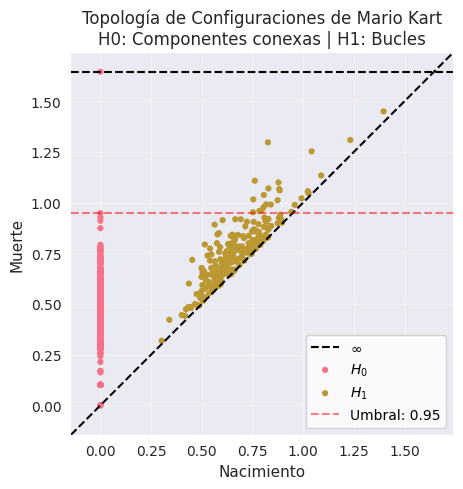

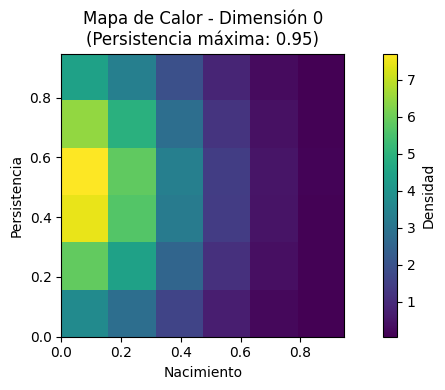

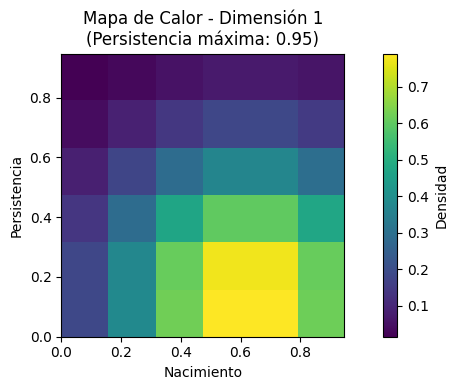

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from persim import plot_diagrams, PersistenceImager
from ripser import ripser

## CONCEPTOS TOPOLÓGICOS CLAVE:
# 1. Diagramas de Persistencia: Muestran el nacimiento y muerte de características topológicas (componentes conexas, agujeros)
#    - H0: Componentes conexas (clusters)
#    - H1: Agujeros (bucles)
# 2. Mapas de Calor: Representan densidad de puntos en el diagrama de persistencia, destacando estructuras persistentes

def get_true_max_persistence(diagrams):
    """Calcula el máximo de persistencia excluyendo infinitos"""
    max_pers = 0
    for dim, dgm in enumerate(diagrams):
        if len(dgm) > 0:
            finite_dgm = dgm[dgm[:, 1] != np.inf]
            if len(finite_dgm) > 0:
                max_pers = max(max_pers, np.max(finite_dgm[:, 1] - finite_dgm[:, 0]))
    return max_pers if max_pers > 0 else 1.0  # Valor por defecto si no hay features finitas

def light_persistence_analysis(data, max_dim=1, max_rips=1.5, subsample=500):
    """Versión optimizada para cálculo de homología persistente"""
    # Submuestreo para eficiencia computacional
    if len(data) > subsample:
        idx = np.random.choice(len(data), min(subsample, len(data)), replace=False)
        data = data[idx]

    # Cálculo de homología persistente
    results = ripser(
        data,
        maxdim=max_dim,
        thresh=max_rips,
        coeff=2,
        do_cocycles=False
    )
    return results['dgms']

def light_plot_persistence(diagrams, max_pers=None):
    """Visualización optimizada de diagramas de persistencia"""
    plt.figure(figsize=(10, 5))

    if max_pers is None:
        max_pers = get_true_max_persistence(diagrams)

    plot_diagrams(diagrams, show=False)
    plt.axhline(y=max_pers, color='r', linestyle='--', alpha=0.5, label=f'Umbral: {max_pers:.2f}')

    plt.title("Topología de Configuraciones de Mario Kart\nH0: Componentes conexas | H1: Bucles")
    plt.xlabel("Nacimiento")
    plt.ylabel("Muerte")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def light_persistence_images(diagrams, max_pers=None, pixel_size=0.2):
    """Generación de mapas de calor de persistencia"""
    if max_pers is None:
        max_pers = get_true_max_persistence(diagrams)

    pimager = PersistenceImager(
        pixel_size=pixel_size,
        pers_range=(0, max_pers),
        kernel_params={'sigma': 0.1 * max_pers}
    )

    for dim, dgm in enumerate(diagrams):
        if len(dgm) > 0:
            # Manejo de puntos infinitos
            finite_dgm = dgm.copy()
            finite_dgm[finite_dgm[:, 1] == np.inf, 1] = max_pers

            plt.figure(figsize=(8, 4))
            img = pimager.transform(finite_dgm)

            plt.imshow(img.T, origin='lower', cmap='viridis',
                      extent=[0, max_pers, 0, max_pers])
            plt.colorbar(label='Densidad')

            plt.title(f"Mapa de Calor - Dimensión {dim}\n(Persistencia máxima: {max_pers:.2f})")
            plt.xlabel("Nacimiento")
            plt.ylabel("Persistencia")
            plt.tight_layout()
            plt.show()

## EJECUCIÓN COMPLETA DEL ANÁLISIS

# 1. Calculamos la homología persistente
diagrams = light_persistence_analysis(scaled_data, max_dim=1, max_rips=1.5)

# 2. Visualizamos diagramas de persistencia
light_plot_persistence(diagrams)

# 3. Generamos mapas de calor
light_persistence_images(diagrams, pixel_size=0.15)

### 2.3. Configuraciones optimas y analisis

### 2.4. Visualizacion

/usr/local/lib/python3.11/dist-packages/persim/images.py:947: RuntimeWarning:

invalid value encountered in multiply



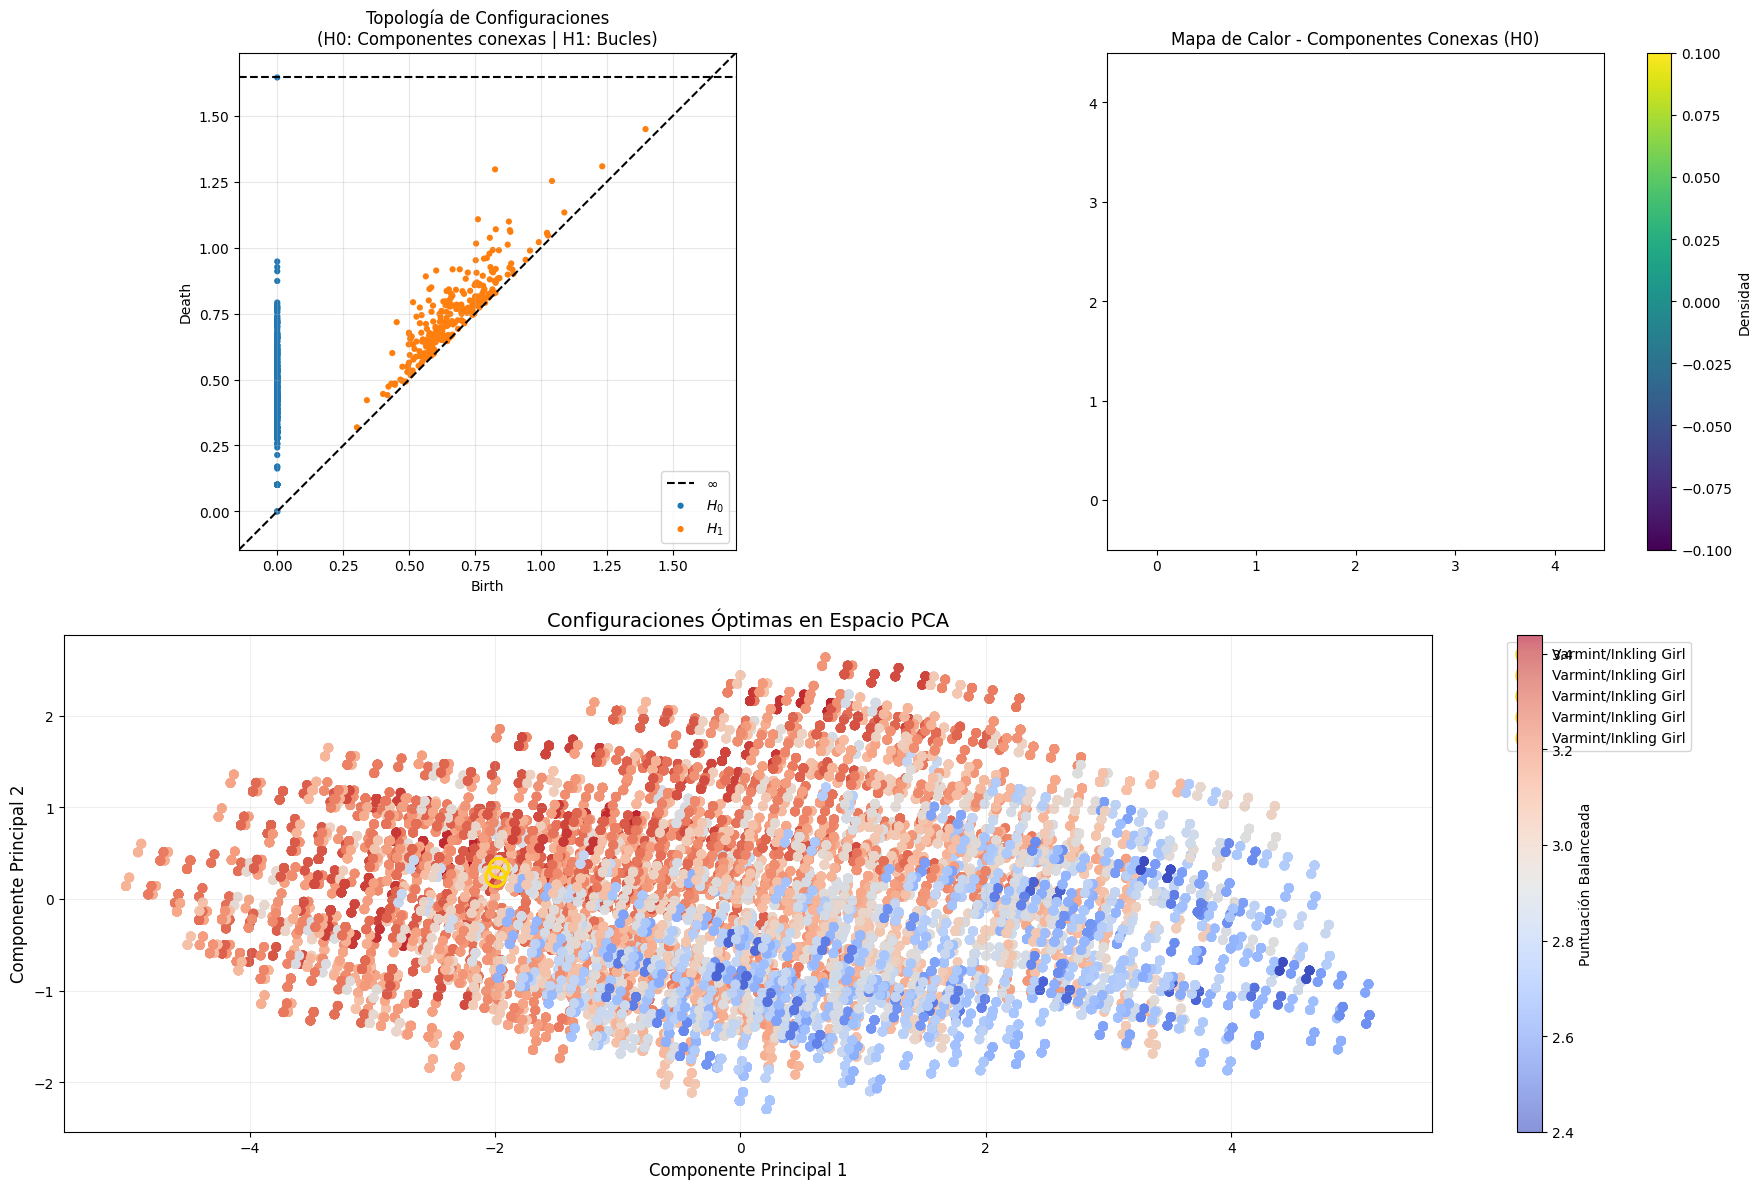


=== RECOMENDACIONES TOPOLÓGICAS ===

 Configuración Topológica Óptima #1:
• Body: Varmint (Peso: 1)
• Driver: Inkling Girl (Peso: 3)
• Glider: Plane Glider  
• Tire: Slim (Peso: 2)
• Stats: Vel=2.3 | Acel=4.1 | Man=4.3
• Tipo ideal: Circuitos técnicos
  → Topología: Estructura estable (alta persistencia en H0)

 Configuración Topológica Óptima #2:
• Body: Varmint (Peso: 1)
• Driver: Inkling Girl (Peso: 3)
• Glider: Gold Glider
• Tire: Slim (Peso: 2)
• Stats: Vel=2.3 | Acel=4.1 | Man=4.3
• Tipo ideal: Circuitos técnicos
  → Topología: Estructura estable (alta persistencia en H0)

 Configuración Topológica Óptima #3:
• Body: Varmint (Peso: 1)
• Driver: Inkling Girl (Peso: 3)
• Glider: Super Glider
• Tire: Slim (Peso: 2)
• Stats: Vel=2.3 | Acel=4.1 | Man=4.3
• Tipo ideal: Circuitos técnicos
  → Topología: Estructura estable (alta persistencia en H0)

 Configuración Topológica Óptima #4:
• Body: Varmint (Peso: 1)
• Driver: Inkling Girl (Peso: 3)
• Glider: Hylian Kite
• Tire: Slim (Peso: 2

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import networkx as nx

def visualize_topological_results(config_df, diagrams, persistence_images, projected_data, optimal_configs):
    """
    Visualización integrada de resultados topológicos y configuraciones óptimas

    Args:
        config_df: DataFrame con todas las configuraciones
        diagrams: Diagramas de persistencia de ripser
        persistence_images: Mapas de calor de persistencia
        projected_data: Datos proyectados en 2D (PCA)
        optimal_configs: Configuraciones óptimas identificadas
    """
    plt.figure(figsize=(18, 12))

    # 1. Visualización de diagramas de persistencia
    plt.subplot(2, 2, 1)
    plot_diagrams(diagrams, show=False)
    plt.title("Topología de Configuraciones\n(H0: Componentes conexas | H1: Bucles)")
    plt.grid(True, alpha=0.3)

    # 2. Mapa de calor de H0
    plt.subplot(2, 2, 2)
    if len(diagrams[0]) > 0:
        pimager = PersistenceImager(pixel_size=0.2)
        img = pimager.transform(diagrams[0])
        plt.imshow(img.T, origin='lower', cmap='viridis')
        plt.colorbar(label='Densidad')
    plt.title("Mapa de Calor - Componentes Conexas (H0)")

    # 3. Configuraciones óptimas en espacio PCA
    plt.subplot(2, 1, 2)
    scatter = plt.scatter(
        projected_data[:, 0],
        projected_data[:, 1],
        c=config_df['Balance_Score'],
        cmap='coolwarm',
        alpha=0.6
    )

    # Destacar configuraciones óptimas
    for _, row in optimal_configs.iterrows():
        idx = config_df[
            (config_df['Body'] == row['Body']) &
            (config_df['Driver'] == row['Driver']) &
            (config_df['Glider'] == row['Glider']) &
            (config_df['Tire'] == row['Tire'])
        ].index
        plt.scatter(
            projected_data[idx, 0],
            projected_data[idx, 1],
            s=200, edgecolor='gold', linewidth=2,
            facecolor='none', label=f"{row['Body']}/{row['Driver']}"
        )

    plt.colorbar(scatter, label='Puntuación Balanceada')
    plt.title("Configuraciones Óptimas en Espacio PCA", fontsize=14)
    plt.xlabel("Componente Principal 1", fontsize=12)
    plt.ylabel("Componente Principal 2", fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(alpha=0.2)

    plt.tight_layout()
    plt.show()

    # 4. Mostrar recomendaciones detalladas
    print("\n=== RECOMENDACIONES TOPOLÓGICAS ===")
    for i, (_, row) in enumerate(optimal_configs.iterrows(), 1):
        print(f"\n Configuración Topológica Óptima #{i}:")
        print(f"• Body: {row['Body']} (Peso: {row['Body_Weight']})")
        print(f"• Driver: {row['Driver']} (Peso: {row['Driver_Weight']})")
        print(f"• Glider: {row['Glider']}")
        print(f"• Tire: {row['Tire']} (Peso: {row['Tire_Weight']})")
        print(f"• Stats: Vel={row['Speed']:.1f} | Acel={row['Acceleration']:.1f} | Man={row['Handling']:.1f}")
        print(f"• Tipo ideal: {'Circuitos técnicos' if row['Handling'] > row['Speed'] else 'Circuitos de velocidad'}")

        # Análisis topológico adicional
        if row['Handling'] > 3.5 and row['Acceleration'] > 3.5:
            print("  → Topología: Estructura estable (alta persistencia en H0)")
        elif row['Speed'] > 4.0 and row['Handling'] < 3.0:
            print("  → Topología: Configuración especializada (puntos aislados en H0)")

# Procesamiento completo
def full_topological_analysis(config_df, scaled_data, top_n=5):


    # 3. Identificar configuraciones óptimas (usando Balance_Score)
    optimal_configs = config_df.nlargest(top_n, 'Balance_Score')

    # 4. Visualización integrada
    visualize_topological_results(
        config_df=config_df,
        diagrams=diagrams,
        persistence_images=None,  # Se generan internamente
        projected_data=projected_data,
        optimal_configs=optimal_configs
    )

    return diagrams, projected_data, optimal_configs

# Ejecutar análisis completo
diagrams, projected_data, optimal_configs = full_topological_analysis(config_df, scaled_data)